Machine learning model for predicting fuel consumption.

Hyperparameter tuning and training of various linear and tree-based algorithms.

Comparison of optimally tuned models.

Perform model tuning and validation on splits of 'train' set (years 2019, 2020).

Perform final model testing on 'test' set (year 2021).

Input(s): 
- df_ml_[variant]_all.csv
- ML_FC_variants_generated.csv (for feature sets)
- ML_FC_Exploration_all_feature_names_desc.csv (for correlation plot)

Output(s): 
- Git Untracked Data:
    - Model dataframes with fitted estimators after certain steps
        - _mdl_df_base.pkl
        - _mdl_df_best.pkl
        - _mdl_df_kf.pkl
        - _mdl_df_compare.pkl
- Git Tracked Data:
    - parameters: _params.csv
    - stats comparisons for residual and fuel consumption: e.g. _best_fc.csv

Note: Outlier filtering operates on 'residual' = log1p(report_fc) - log1p(cal_fc)

## Preamble

In [1]:
import os
import string
import sys
# from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from xgboost import XGBRegressor
sys.path.append("../code/.")
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
# from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
# from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    # RandomizedSearchCV,
    # cross_val_score,
    # cross_validate,
    # train_test_split,
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from catboost import CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor
# from sklearn.tree import DecisionTreeRegressor
# from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, matthews_corrcoef, make_scorer #, PredictionErrorDisplay
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate, LeaveOneOut, LeavePOut, KFold, RepeatedKFold
import seaborn as sns
import pickle # for saving models
from sklearn.inspection import permutation_importance # for permutation feature importance
import time #for timing


## Global Settings

In [2]:
def total_error(y_true, y_pred):
    return np.sum(y_pred - y_true)

In [3]:
# create a wrapper function for the 25th percentile
def percentile_25(x):
    return np.percentile(x, 25)

# create a wrapper function for the 75th percentile
def percentile_75(x):
    return np.percentile(x, 75)

def percentile_eighth(x):
    return np.percentile(x, 12.5)

test_criteria = {
    "test2021" : ('year', '2021', 'set'),
    "test2020" : ('year', '2020', 'set'),
    "testlowrelspeed" : ('speed_rel', 'x < np.median', 'function'),
    "testhighrelspeed" : ('speed_rel', 'x > np.median', 'function'),
    "testlowrelseaspeed" : ('speed_sea_rel', 'x < np.median', 'function'),
    "testhighrelseaspeed" : ('speed_sea_rel', 'x > np.median', 'function'),
    "testhighseaspeedvar" : ('speed_sea_var', 'x > np.nanmedian', 'function'),
    "testouterrelseaspeed" : ('speed_sea_rel', ('x < percentile_25', '|', 'x > percentile_75'), '2function'),
    "testinnerrelseaspeed" : ('speed_sea_rel', ('x > percentile_25', '&', 'x < percentile_75'), '2function'),
    "testlarge" : ('Dwt', 'x > np.median', 'function'),
    "testsmall" : ('Dwt', 'x < np.median', 'function'),
    "testquart1relseaspeed" : ('speed_sea_rel', 'x <= percentile_25', 'function'),
    "testquart2relseaspeed" : ('speed_sea_rel', ('x > percentile_25', '&', 'x <= np.median'), '2function'),
    "testquart3relseaspeed" : ('speed_sea_rel', ('x > np.median', '&', 'x <= percentile_75'), '2function'),
    "testquart4relseaspeed" : ('speed_sea_rel', 'x > percentile_75', 'function'),
    "testquart1dwt" : ('Dwt', 'x <= percentile_25', 'function'),
    "testquart2dwt" : ('Dwt', ('x > percentile_25', '&', 'x <= np.median'), '2function'),
    "testquart3dwt" : ('Dwt', ('x > np.median', '&', 'x <= percentile_75'), '2function'),
    "testquart4dwt" : ('Dwt', 'x > percentile_75', 'function'),
    "testlowdraught" : ('draught_mean', 'x < np.median', 'function'),
    "testhighdraught" : ('draught_mean', 'x > np.median', 'function'),
    "testeighthrandom" : ('random', 'x < percentile_eighth', 'function'),
    "trainquart1relseaspeed" : ('speed_sea_rel', 'x > percentile_25', 'function'),
    "trainquart2relseaspeed" : ('speed_sea_rel', ('x <= percentile_25', '|', 'x > np.median'), '2function'),
    "trainquart3relseaspeed" : ('speed_sea_rel', ('x <= np.median', '|', 'x > percentile_75'), '2function'),
    "trainquart4relseaspeed" : ('speed_sea_rel', 'x <= percentile_75', 'function')
}

In [4]:
random_seed = 2652124
target = 'fe' # 'fe'
no_transform = True # if True, do not transform target or predictors
feature_set = 'djdrank10' #'djdrank10' ##'calc' #'speeddist' #'nocalcs' # feature set to use (defined herein)
test_set_criteria = ["trainquart2relseaspeed"]
# test_set_criteria = ["testquart1relseaspeed", "testhighdraught"]
fast_only = True # if True, only run models that are fast

In [5]:
np.random.seed(random_seed)

Target = target.upper()
target_names = {
    'fc' : 'Fuel Consumption',
    'fe' : 'Fuel Efficiency'
}
if target not in target_names.keys():
    sys.exit('Invalid target specification')
Target_Name = target_names[target]

# Default to log transform target
y_transformer_func = np.log1p
y_transformer_inverse_func = np.expm1

tol_type = 'abs' # 'rel' or 'abs' tolerance type for subsetting 'valid' data based on distance discrepancy

outlier_threshold = np.Inf #3 # number of standard deviations from the mean to consider a point an outlier

test_exp = ['' for _ in range(len(test_set_criteria))]

for index, test_set_criterion in enumerate(test_set_criteria):
    print(test_set_criterion)
    if test_criteria[test_set_criterion][2] == 'set':
        test_exp[index] = "df_ml_raw['" + test_criteria[test_set_criterion][0] + "'].isin([" + test_criteria[test_set_criterion][1] + "])"
    elif test_criteria[test_set_criterion][2] == 'function':
        test_exp[index] = "df_ml_raw['" + test_criteria[test_set_criterion][0] + "'].apply(lambda x: " + test_criteria[test_set_criterion][1]  + "(df_ml_raw['" + test_criteria[test_set_criterion][0] + "']))"
    elif test_criteria[test_set_criterion][2] == '2function':
        test_exp[index] = "df_ml_raw['" + test_criteria[test_set_criterion][0] + "'].apply(lambda x: (" + test_criteria[test_set_criterion][1][0]  + "(df_ml_raw['" + test_criteria[test_set_criterion][0] + "'])) " + test_criteria[test_set_criterion][1][1] + " (" + test_criteria[test_set_criterion][1][2]  + "(df_ml_raw['" + test_criteria[test_set_criterion][0] + "'])))"

test_exp = " & ".join(test_exp)
train_exp = "~(" + test_exp + ")"

# if no_transform:
#     y_transformer_func = None
#     y_transformer_inverse_func = None

validation_stats = {
    # my name: function, printing name, greater_is_better
    'mae': (mean_absolute_error, 'MAE', False),
    'te': (total_error, 'TE', False), # greater_is_better is incorrect, but required for make_scorer
    'mse': (mean_squared_error, 'MSE', False),
    'mape': (mean_absolute_percentage_error, 'MAPE', False),
    'r2': (r2_score, 'R²', True),
    # 'corr': (corr2, 'Correlation'), # doesn't work for cv
    # 'corr': (matthews_corrcoef, 'corr') # doesn't work!
} 

cv_folds = 5
scoring = 'mae'
cv_scoring = validation_stats[scoring][0].__name__ if validation_stats[scoring][2] else 'neg_' + validation_stats[scoring][0].__name__
cv_scoring = 'r2' if cv_scoring == 'r2_score' else cv_scoring

eval_types_dict = {
    'gridsearch': cv_folds,
    'lpo': LeavePOut(2),
    'kfold': 10,
    'repkfold': RepeatedKFold(n_repeats=3, n_splits=10, random_state=random_seed)
}
train_eval_type = 'repkfold' #'gridsearch' # one of keys of eval_types_dict

max_cores = 6

sns.set_theme(
    context='paper',
    palette='colorblind', # deep, dark, bright, colorblind
    font_scale=1.4
    ) 
sns.set_style('whitegrid',
    {'axes.grid': False})
plt.rcParams["font.family"] = "Bitstream Vera Sans"
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['legend.title_fontsize'] = 15
plt.rcParams['legend.frameon'] = False

# Paths for local
# datapath = 'Machine Learning/data/'
# readdatapath = 'src/tracked_data/'
# trackeddatapath = 'Machine Learning/tracked_data/'
# plotpath = 'Machine Learning/plots/'
# tablepath = 'Machine Learning/tables/'

# Paths for CC
datapath = 'data/'
readdatapath = 'tracked_data/'
trackeddatapath = 'tracked_data/'
plotpath = 'plots/'
tablepath = 'tables/'

fileprefix = 'ML_' + Target + '_F' + feature_set + '_' + ''.join(test_set_criteria) + '_' #'_rel_' #+ '_nofilter_' 
if test_criteria[test_set_criterion][0] == "random":
    fileprefix += str(random_seed) + '_'
if no_transform:
    fileprefix += 'linear_'
if fast_only:
    fileprefix += 'fast_'
model_df_filename = 'mdl_df'

start_time = time.time()

param_vars = [
    'random_seed',  
    'target',
    'y_transformer_func',
    'y_transformer_inverse_func',
    'tol_type',
    'outlier_threshold',
    'feature_set',
    'no_transform',
    'test_exp',
    'train_exp',
    'cv_folds',
    'cv_scoring',
    'train_eval_type',
    'eval_types_dict',
    'datapath',
    'trackeddatapath',
    'plotpath',
    'fileprefix',
    'model_df_filename']

# Load feature sets and check if specified one is valid
feature_sets_df = pd.read_csv(trackeddatapath + 'ML_FC_variants_generated.csv')
variants = feature_sets_df.select_dtypes(include=bool).columns.tolist()
if (feature_set not in variants) & (feature_set not in list(feature_sets_df['variable'])):
    sys.exit('Invalid feature set')

# safeguard against overwriting if slow to run
if ~fast_only & os.path.exists(trackeddatapath + fileprefix + 'params.csv'):
    sys.exit('File already exists. Delete params csv file to overwrite all related data.')


pd.DataFrame(
    [(i, globals()[i]) for i in param_vars],
    columns = ['parameter', 'value']
    ).to_csv(
        trackeddatapath + fileprefix + 'params.csv',
        index = False)

print(f"Started at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))}")

trainquart2relseaspeed
Started at: 2024-09-09 17:03:48


### Functions

In [6]:
def col_search(searchkey):
    """
    Search for column names containing a given string and print summary statistics. (case insensitive)
    """
    colname_matches = [col for col in df_ml.columns if searchkey.lower() in col.lower()]
    if len(colname_matches) > 0:
        print(colname_matches)
        df_ml[colname_matches].describe()
        for col in colname_matches:
            if df_ml[col].nunique() <= 10:
                print(col)
                print(df_ml[colname_matches].value_counts())
    else:
        print('No matches found')

def plot_45deg_line(x, y, xylinelabel):
    """
    Create a two-way plot with a 45-degree line.
    """
    upper = 1.01*max(x.max(), y.max())
    lower = 0.99*min(x.min(), y.min())
    x0 = np.linspace(lower, upper, 100)
    plt.plot(x0, x0, alpha=0.8, color = 'black', linestyle='dashed', label=xylinelabel)

def two_way_plot(x, y, data=None, hue=None, alpha=0.5, title=None, xlabel=None, ylabel=None, legend=True, legend_title=None, line_labels=False, regline=False, savepath=None):
    """
    Create a two-way plot with a regression line.
    """
    plt.figure(figsize=(5, 5), dpi=300)
    sns.scatterplot(data=data, x=x, y=y, hue=hue, alpha=alpha)
    if line_labels:
        reglinelabel='Linear regression'
        xylinelabel='x=y'
    else:
        reglinelabel=None
        xylinelabel=None

    if data is None:
        plot_45deg_line(x, y, xylinelabel)
    else:
        plot_45deg_line(data[x], data[y], xylinelabel)
    
    if regline:
        sns.regplot(
            data=data, x=x, y=y, 
            scatter=False,
            line_kws={'linestyle':'dotted'},
            label=reglinelabel,
            color='black')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
        plt.legend(
            title=legend_title,
            bbox_to_anchor=(1.05, 0.5),
            loc='center left')
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()

def plot_45deg_line_new(x, y, ax):
    """
    Create a two-way plot with a 45-degree line.
    """
    upper = max(x.max(), y.max()) + 0.1
    lower = min(x.min(), y.min()) - 0.1
    x0 = np.linspace(lower, upper, 100)
    ax.plot(x0, x0, color='black', label='x=y')

def two_way_plot_new(x, y, data=None, hue=None, alpha=0.5, title=None, xlabel=None, ylabel=None, legend_title=None, regline=False, savepath=None):
    """
    Create a two-way plot with a regression line.
    """
    fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
    sns.scatterplot(data=data, x=x, y=y, hue=hue, alpha=alpha, ax=ax)
    if regline:
        sns.regplot(data=data, x=x, y=y, scatter=False, line_kws={'linestyle':'dashed'}, label='regression line', color='red', ax=ax)
    if data is None:
        plot_45deg_line_new(x, y, ax=ax)
    else:
        plot_45deg_line_new(data[x], data[y], ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(title=legend_title)
    if savepath:
        plt.savefig(savepath)
    plt.show()
    return ax

# def make_estimator_default(scaling, mdlclass):
#     if scaling:
#         estimator = make_pipeline(preprocessor_scaling, mdlclass)
#     elif ~scaling:
#         estimator = make_pipeline(preprocessor_noscaling, mdlclass)
#     return estimator

def make_estimator(scaling, classname, y_transformer_func=None, y_transformer_inverse_func=None, random_seed=None, params={}):
    if not params:
        if classname == 'LinearRegression':
            estimator = make_pipeline(preprocessor_noscaling_drop, globals()[classname]())
        elif scaling:
            estimator = make_pipeline(preprocessor_scaling, globals()[classname](random_state=random_seed))
        elif ~scaling:
            estimator = make_pipeline(preprocessor_noscaling, globals()[classname](random_state=random_seed))
    else:
        if scaling:
            estimator = make_pipeline(preprocessor_scaling, globals()[classname](random_state=random_seed, **params))
        elif ~scaling:
            estimator = make_pipeline(preprocessor_noscaling, globals()[classname](random_state=random_seed, **params))

    estimator = TransformedTargetRegressor(regressor=estimator,
                                           func=y_transformer_func, inverse_func=y_transformer_inverse_func)
    return estimator
    
def calculate_stats(y_true, y_pred, data=None, stats_dict=None):
    """
    Create a dictionary of statistics for a model.
    """
    if data is not None:
        y_true = data[y_true]
        y_pred = data[y_pred]

    values_dict = {}
    names_dict = {}
    for stat in stats_dict.keys():
        values_dict[stat] = stats_dict[stat][0](y_true, y_pred)
        names_dict[stat] = stats_dict[stat][1]
    return {'stats' : values_dict, 'names' : names_dict}    

def create_legend_title(stats_dict):
    """
    Create a legend title for a plot based on a dictionary of statistics.
    """
    legend_title = ''
    for key in stats_dict['stats']:
        legend_title += f"{stats_dict['names'][key]}: {round(stats_dict['stats'][key],3)}\n"
    return legend_title

def cross_validate_stats(X, y, estimator, cv, validation_stats, max_cores):
    cv_scores = cross_validate(
        estimator,
        X, y,
        cv=cv,
        scoring={key: make_scorer(stat[0], greater_is_better=stat[2]) for key, stat in validation_stats.items()},
        # scoring=make_scorer(r2_score, greater_is_better=True),
        n_jobs=max_cores)

    means = [np.mean(value) for key, value in cv_scores.items() if key.startswith('test_')]
    # take negative where approriate because cross_validate returns negatives if ~greater_is_better
    means = [means[index]*(1 if value[2] else -1) for index, value in enumerate(validation_stats.values())]
    sds = [np.std(value) for key, value in cv_scores.items() if key.startswith('test_')]
    return {"means": dict(zip(validation_stats.keys(), means)),
            "sds": dict(zip(validation_stats.keys(), sds)),
            "names": {keys: values[1] for keys, values in validation_stats.items()}}

def format_cv_results(grid_search):
    """
    Format the results of a grid search as a pandas DataFrame.
    """
    cv_results = pd.DataFrame(grid_search.cv_results_)[['param_gradientboostingregressor__learning_rate', 'param_gradientboostingregressor__max_depth', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score')
    # shorten column names
    cv_results.columns = cv_results.columns.str.removeprefix('param_gradientboostingregressor__')
    cv_results.columns = cv_results.columns.str.replace('_score', '_' + cv_scoring)
    print(f"Model: { grid_search.estimator.named_steps['gradientboostingregressor'].__class__.__name__ }")
    return cv_results

def tribble(columns, *data):
    """
    Create a pandas DataFrame in a read-able format, like R's 'tribble' function.
    """
    return pd.DataFrame(
        data=list(zip(*[iter(data)]*len(columns))),
        columns=columns
    )

def model_stats_comparison_table(stats_col, params_col, estimator_col, mdl_df, stat_key='stats'):
    """
    Create a pandas DataFrame of statistics for multiple models.
    Args: 
        stats_col: name of column containing statistics
        estimator_col: name of column containing fitted estimators
    Returns:
        pandas DataFrame
    """

    compare_df = mdl_df.loc[:, [stats_col, estimator_col, params_col, 'class_name']]
    
    compare_df[stats_col] = compare_df[stats_col].apply(lambda x: x[stat_key])

    for key in compare_df[stats_col].iloc[0].keys():
        compare_df[key] = compare_df[stats_col].apply(lambda x: x[key])

    compare_df['params'] = compare_df.apply(lambda row: extract_filter_params(row, estimator_col, params_col), axis=1)

    return compare_df.drop([stats_col, estimator_col, params_col], axis=1)

def extract_filter_params(row, estimator_col, params_col_mask): 
    """ 
    Extract and filter the parameters to the ones in params_col and drop parameter name prefix.
    Args:
        row: pandas DataFrame row
        estimator_col: name of column containing fitted estimators
        params_col_mask: name of column containing parameters to keep (should be without model name prefix)
    """
    params = row[estimator_col].regressor.named_steps[row['class_name'].lower()].get_params()
    if row[params_col_mask] is None:
        return None
    else:
        return {k.replace(row['class_name'].lower() + '__', ''): v for k, v in params.items() if k in row[params_col_mask].keys()}

def agg_prediction_by_year(estimator, df, target):
    years = np.sort(df['year'].unique())
    if target == 'fc':
        predictions = [estimator.predict(df.loc[df['year']==year]).sum() for year in years]
    elif target == 'fe':
        predictions = [(estimator.predict(df.loc[df['year']==year])*df.loc[df['year']==year]['distance_sum']).sum() for year in years]
    return pd.DataFrame(predictions, index=pd.Index(years, name='year'), columns=['predict_fc_total'])

## Data Validation and Preprocessing

### Load

In [7]:
df_ml_raw = pd.read_csv(readdatapath + "df_ml_" + tol_type + "_all.csv", low_memory=False)
df_ml_raw.groupby('year').count()

,CVN,imo,Name,mmsi,Ex.Name,Flag.State,Operator,Owner,Group.Owner,Built.Date,...,speed_sea_mean,speed_sea_var,age,residual,log_report_fc,log_cal_fc,distance_difference,distance_difference_rel,jump_distance_frac,within_tol_jumps
year,,,,,,,,,,,,,,,,,,,,,
2019,699,699,699,699,333,699,599,699,699,699,...,699,699,699,699,699,699,699,699,699,699
2020,723,723,723,723,320,723,608,723,723,723,...,723,723,723,723,723,723,723,723,723,723
2021,720,720,720,720,334,720,621,720,720,720,...,720,719,720,720,720,720,720,720,720,720


#### Split Sample

In [8]:
# Create variables for sample splitting
df_ml_raw['speed_rel'] = df_ml_raw['speed_mean']/df_ml_raw['Speed..knots.']
df_ml_raw['speed_sea_rel'] = df_ml_raw['speed_sea_mean']/df_ml_raw['Speed..knots.']

if test_criteria[test_set_criterion][0] == 'random':
    df_ml_raw['random'] = np.random.random_sample(len(df_ml_raw))

In [9]:
# df_ml = pd.read_csv(readdatapath + "df_ml_" + tol_type + "_train.csv", low_memory=False)
df_ml = df_ml_raw.loc[eval(train_exp)]

df_ml.groupby('year').count()

,CVN,imo,Name,mmsi,Ex.Name,Flag.State,Operator,Owner,Group.Owner,Built.Date,...,age,residual,log_report_fc,log_cal_fc,distance_difference,distance_difference_rel,jump_distance_frac,within_tol_jumps,speed_rel,speed_sea_rel
year,,,,,,,,,,,,,,,,,,,,,
2019,174,174,174,174,83,174,149,174,174,174,...,174,174,174,174,174,174,174,174,174,174
2020,184,184,184,184,81,184,154,184,184,184,...,184,184,184,184,184,184,184,184,184,184
2021,177,177,177,177,84,177,147,177,177,177,...,177,177,177,177,177,177,177,177,177,177


#### Create additional variables, set target

In [10]:
# for nicer colors when plotting
df_ml = df_ml.sort_values('year')
df_ml['year_str'] = df_ml['year'].astype(str) 

# efficiency target variable
df_ml['report_fe'] = df_ml['report_fc'] / df_ml['MRV.EU.distance']
df_ml['log_report_fe'] = np.log1p(df_ml['report_fe'])
df_ml['cal_fe'] = df_ml['cal_fc'] / df_ml['distance_sum']
df_ml['log_cal_fe'] = np.log1p(df_ml['cal_fe'])

# OECD variable
df_ml['cubic_meter'] = df_ml['Beam.Mld..m.']*df_ml['Depth.Moulded..m.']*df_ml['LOA..m.']

# Set target variable
df_ml['report_target'] = df_ml['report_' + target]
df_ml['cal_target'] = df_ml['cal_' + target]
df_ml['log_report_target'] = np.log1p(df_ml['report_' + target])
df_ml['log_cal_target'] = np.log1p(df_ml['cal_' + target])
if no_transform:
    df_ml['target_residual'] = df_ml['report_target'] - df_ml['cal_target']
else:
    df_ml['target_residual'] = y_transformer_func(df_ml['report_target']) - y_transformer_func(df_ml['cal_target'])

##### Column name search


In [11]:
col_search('speed')

['Main.Consumption.at.Service.Speed..tpd..', 'Service.Speed..knots.', 'Ballast.Speed..knots.', 'Laden.Speed..knots.', 'Operational.Speed..knots.', 'Eco.Speed...Ballast..knots.', 'Eco.Speed...Laden..knots.', 'Main.Consumption.at.Laden.Speed..tpd.', 'Main.Consumption.at.Ballast.Speed..tpd.', 'Main.Consumption.at.Eco.Speed.Ballast..tpd.', 'Main.Consumption.at.Eco.Speed.Laden..tpd.', 'Speed..knots.', 'Speed.category', 'Maximum.Speed..knots.', 'Aux.Consumption.at.Ballast.Speed..tpd.', 'Aux.Consumption.at.Laden.Speed..tpd.', 'Aux.Consumption.at.Service.Speed..tpd.', 'speed_mean', 'speed_sea_mean', 'speed_sea_var', 'speed_rel', 'speed_sea_rel']
Speed.category
Series([], Name: count, dtype: int64)
Aux.Consumption.at.Service.Speed..tpd.
Series([], Name: count, dtype: int64)


In [12]:
df_ml.loc[:, df_ml.columns.str.contains('Type', case=False)].describe(include='all')

,Main.Engine.Fuel.Type,Type,Old.Type,Owner.Main.Vessel.Type,Alternative.Fuel.Types,Fleet.Type,Self.Unloader.Type,BWMS.Technology.Type,Hull.Type,Alternative.Fuel.Type.Ready,MRV.ship.type
count,535,535,1,531,0,535,2,381,20,1,535
unique,3,4,1,14,0,1,1,8,2,1,3
top,VLS IFO,Bulk Carrier,Products,Bulker,NaN,Bulkers,Conveyor,FILTRATION - ELECTROLYSIS (ELECTRO-CHLORINATIO...,D/Hull,LNG Ready,Bulk carrier
freq,477,463,1,144,NaN,535,2,177,19,1,486


In [13]:
df_ml['Type'].value_counts(dropna=False)

Type
Bulk Carrier          463
Open Hatch Carrier     69
Chip Carrier            2
Ore Carrier             1
Name: count, dtype: int64

### Stats


In [14]:
# Residual (for outlier filtering)
raw_mean = df_ml['residual'].mean()
raw_std = df_ml['residual'].std()
print(f'Raw Data: \n observations: {len(df_ml)} \n residual mean: {raw_mean} \n residual sd: {raw_std}')

Raw Data: 
 observations: 535 
 residual mean: 0.018803259108409038 
 residual sd: 0.24850982394191273


In [15]:
calculate_stats('report_target', 'cal_target', df_ml, validation_stats)

{'stats': {'mae': 0.0187155375357418,
  'te': -0.19125095752611593,
  'mse': 0.0009376703369440139,
  'mape': 0.1858128588304749,
  'r2': -0.08783131889348428},
 'names': {'mae': 'MAE', 'te': 'TE', 'mse': 'MSE', 'mape': 'MAPE', 'r2': 'R²'}}

In [16]:
df_ml[['report_target', 'cal_target']].describe()

,report_target,cal_target
count,535.000000,535.000000
mean,0.099269,0.098911
std,0.029387,0.039931
min,0.030130,0.039924
25%,0.080360,0.075303
50%,0.094210,0.089093
75%,0.110330,0.108215
max,0.206540,0.349833


#### Scatter plot of reported vs calculated target

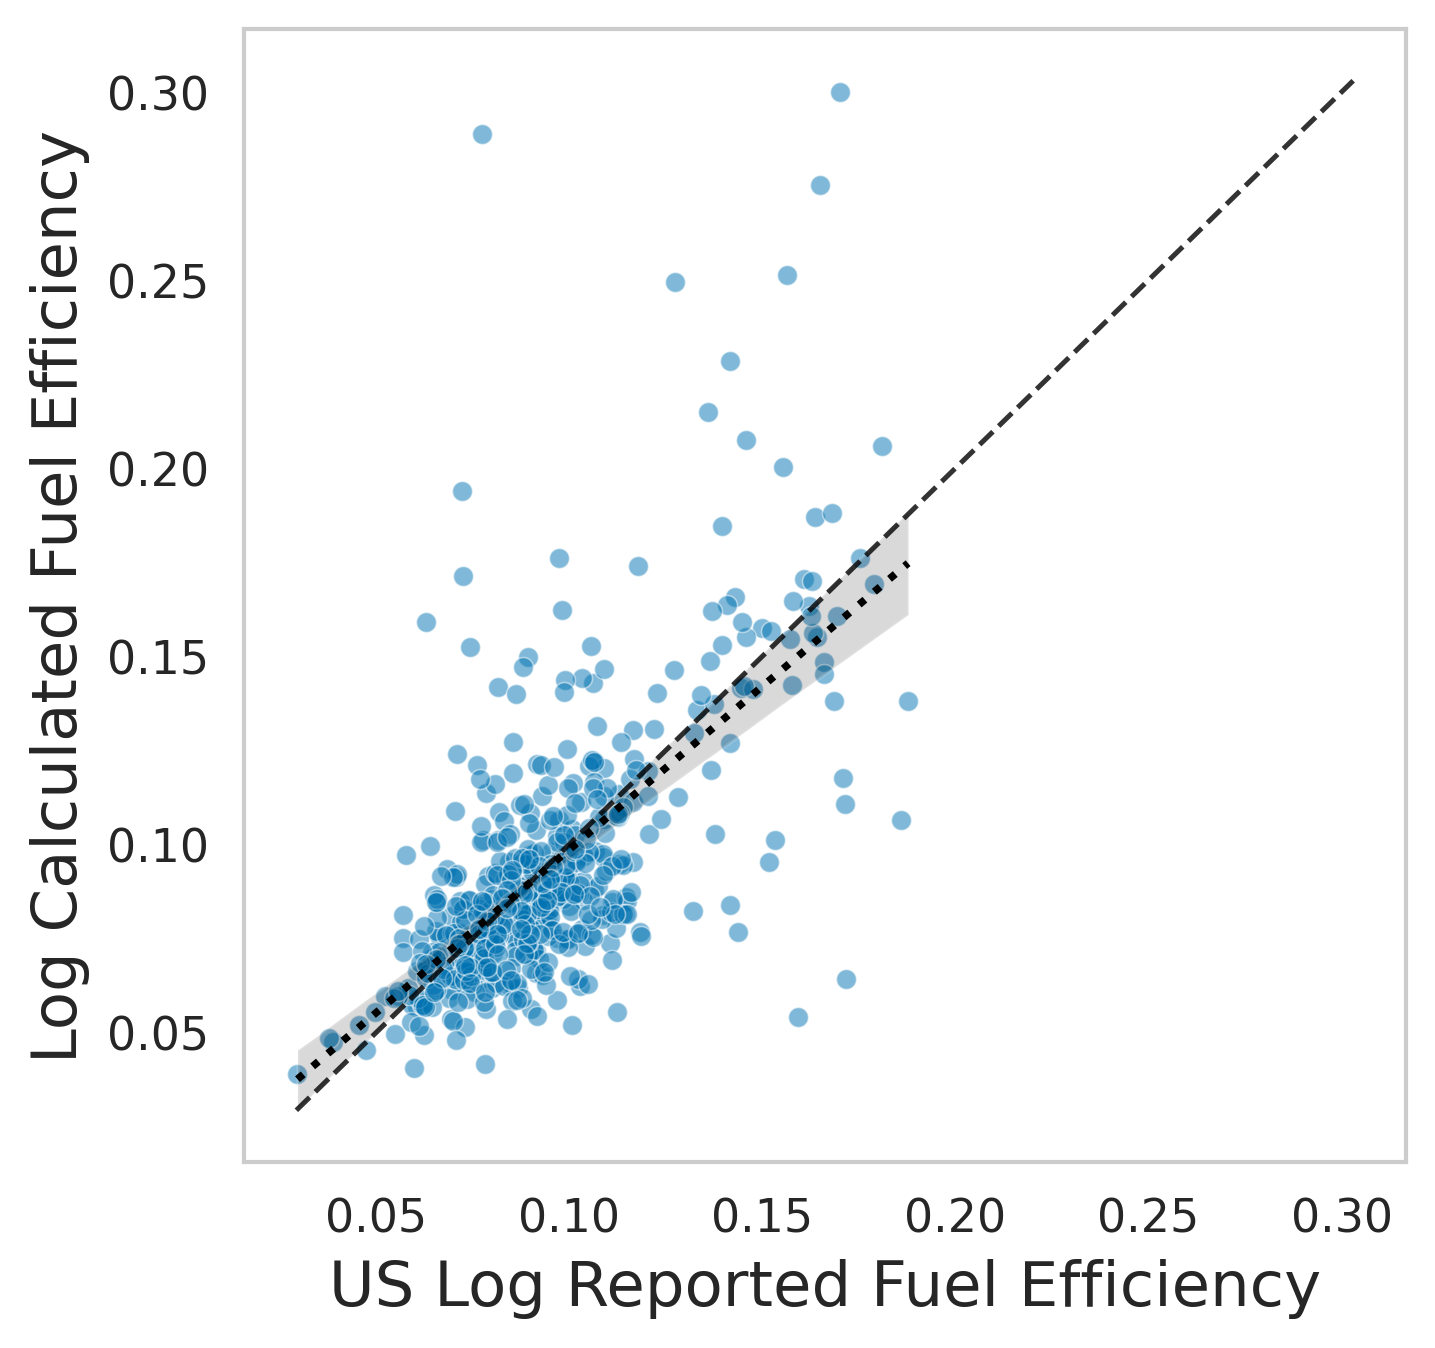

In [17]:
two_way_plot(
     'log_report_target',
     'log_cal_target',
     df_ml,
     # title='Raw Data',
     xlabel='US Log Reported ' + Target_Name,
     ylabel='Log Calculated ' + Target_Name,
     legend=False,
     # legend_title=create_legend_title(stats_raw),
     regline=True,
     savepath=plotpath + fileprefix + 'twoway_target_raw.png')

#### Scatter plot of reported vs calculated fuel efficiency by year using two_way_plot

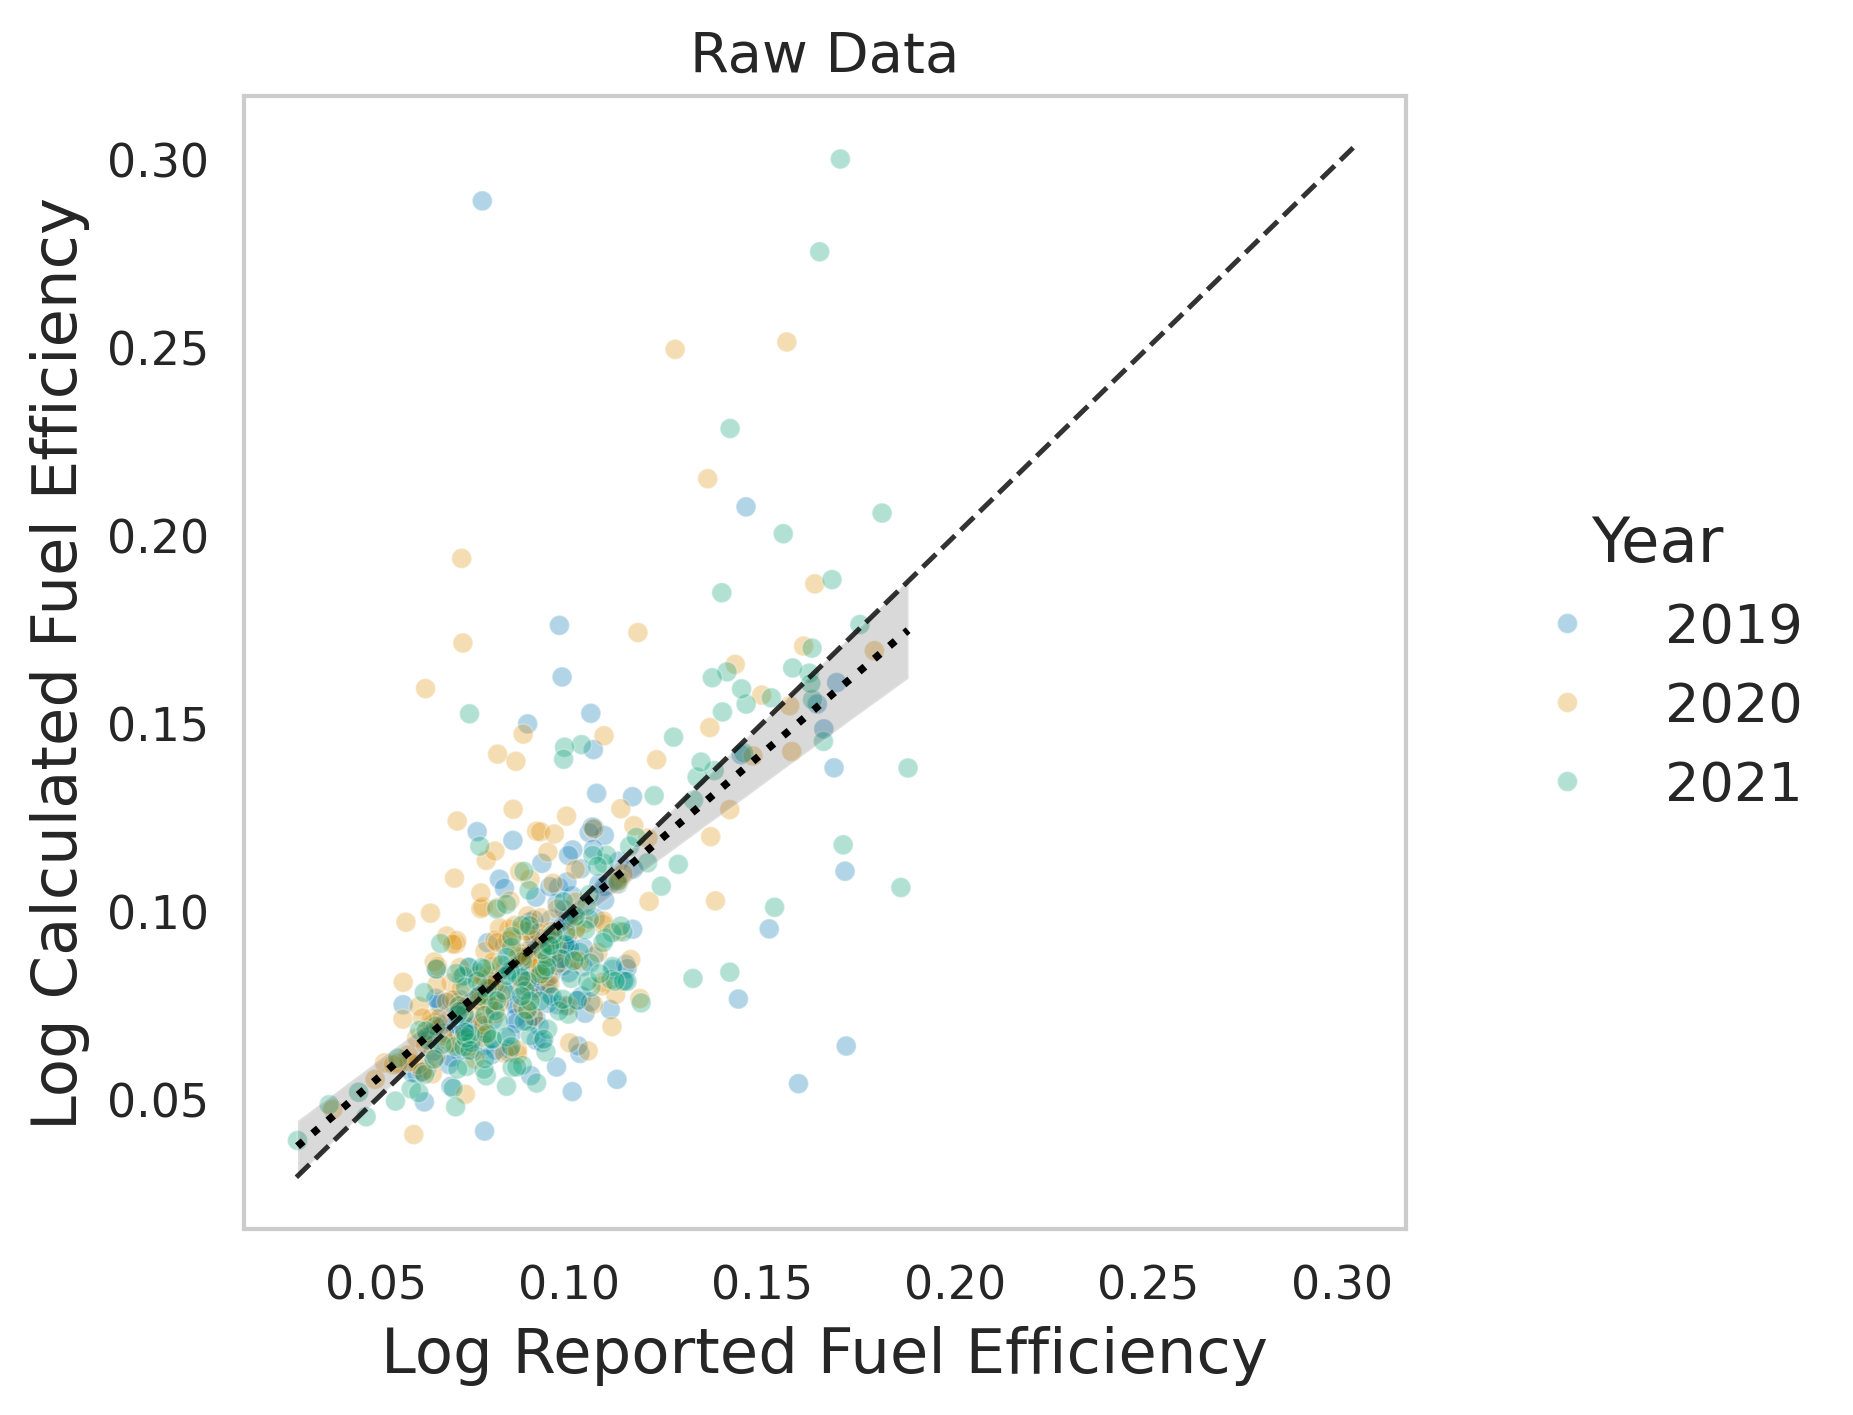

In [18]:
two_way_plot(
    'log_report_target',
    'log_cal_target',
    df_ml,
    hue='year_str',
    alpha=0.3,
    title='Raw Data',
    xlabel='Log Reported ' + Target_Name,
    ylabel='Log Calculated ' + Target_Name,
    regline=True,
    line_labels=False,
    legend_title='Year',
    savepath=plotpath + fileprefix + 'twoway_targetbyyear_raw.png')

### Outliers

#### Explore outliers

In [19]:
df_ml['outlier'] = ~df_ml['residual'].between(
    raw_mean - outlier_threshold * raw_std,
    raw_mean + outlier_threshold * raw_std,
    inclusive='neither')
# df_ml.loc[df_ml['outlier'],:]


In [20]:
df_ml['outlier'].value_counts()

outlier
False    535
Name: count, dtype: int64

In [21]:
# compare means of outliers and non
df_ml.loc[:, ['outlier'] + df_ml.select_dtypes(include=[np.number]).columns.tolist()].groupby('outlier').agg('mean')

,CVN,imo,mmsi,Built.Year,LDT,Demo.Price.LDT,Dwt,Beam.Mld..m.,Draught..m.,Price..NB.,...,report_fe,log_report_fe,cal_fe,log_cal_fe,cubic_meter,report_target,cal_target,log_report_target,log_cal_target,target_residual
outlier,,,,,,,,,,,,,,,,,,,,,
False,1.637846e+07,-7.702433e+06,4.487553e+08,2009.499065,11481.325,595.0,66492.459813,32.234822,12.713047,36.611282,...,0.099269,0.094296,0.098911,0.093694,128667.232893,0.099269,0.098911,0.094296,0.093694,0.000357


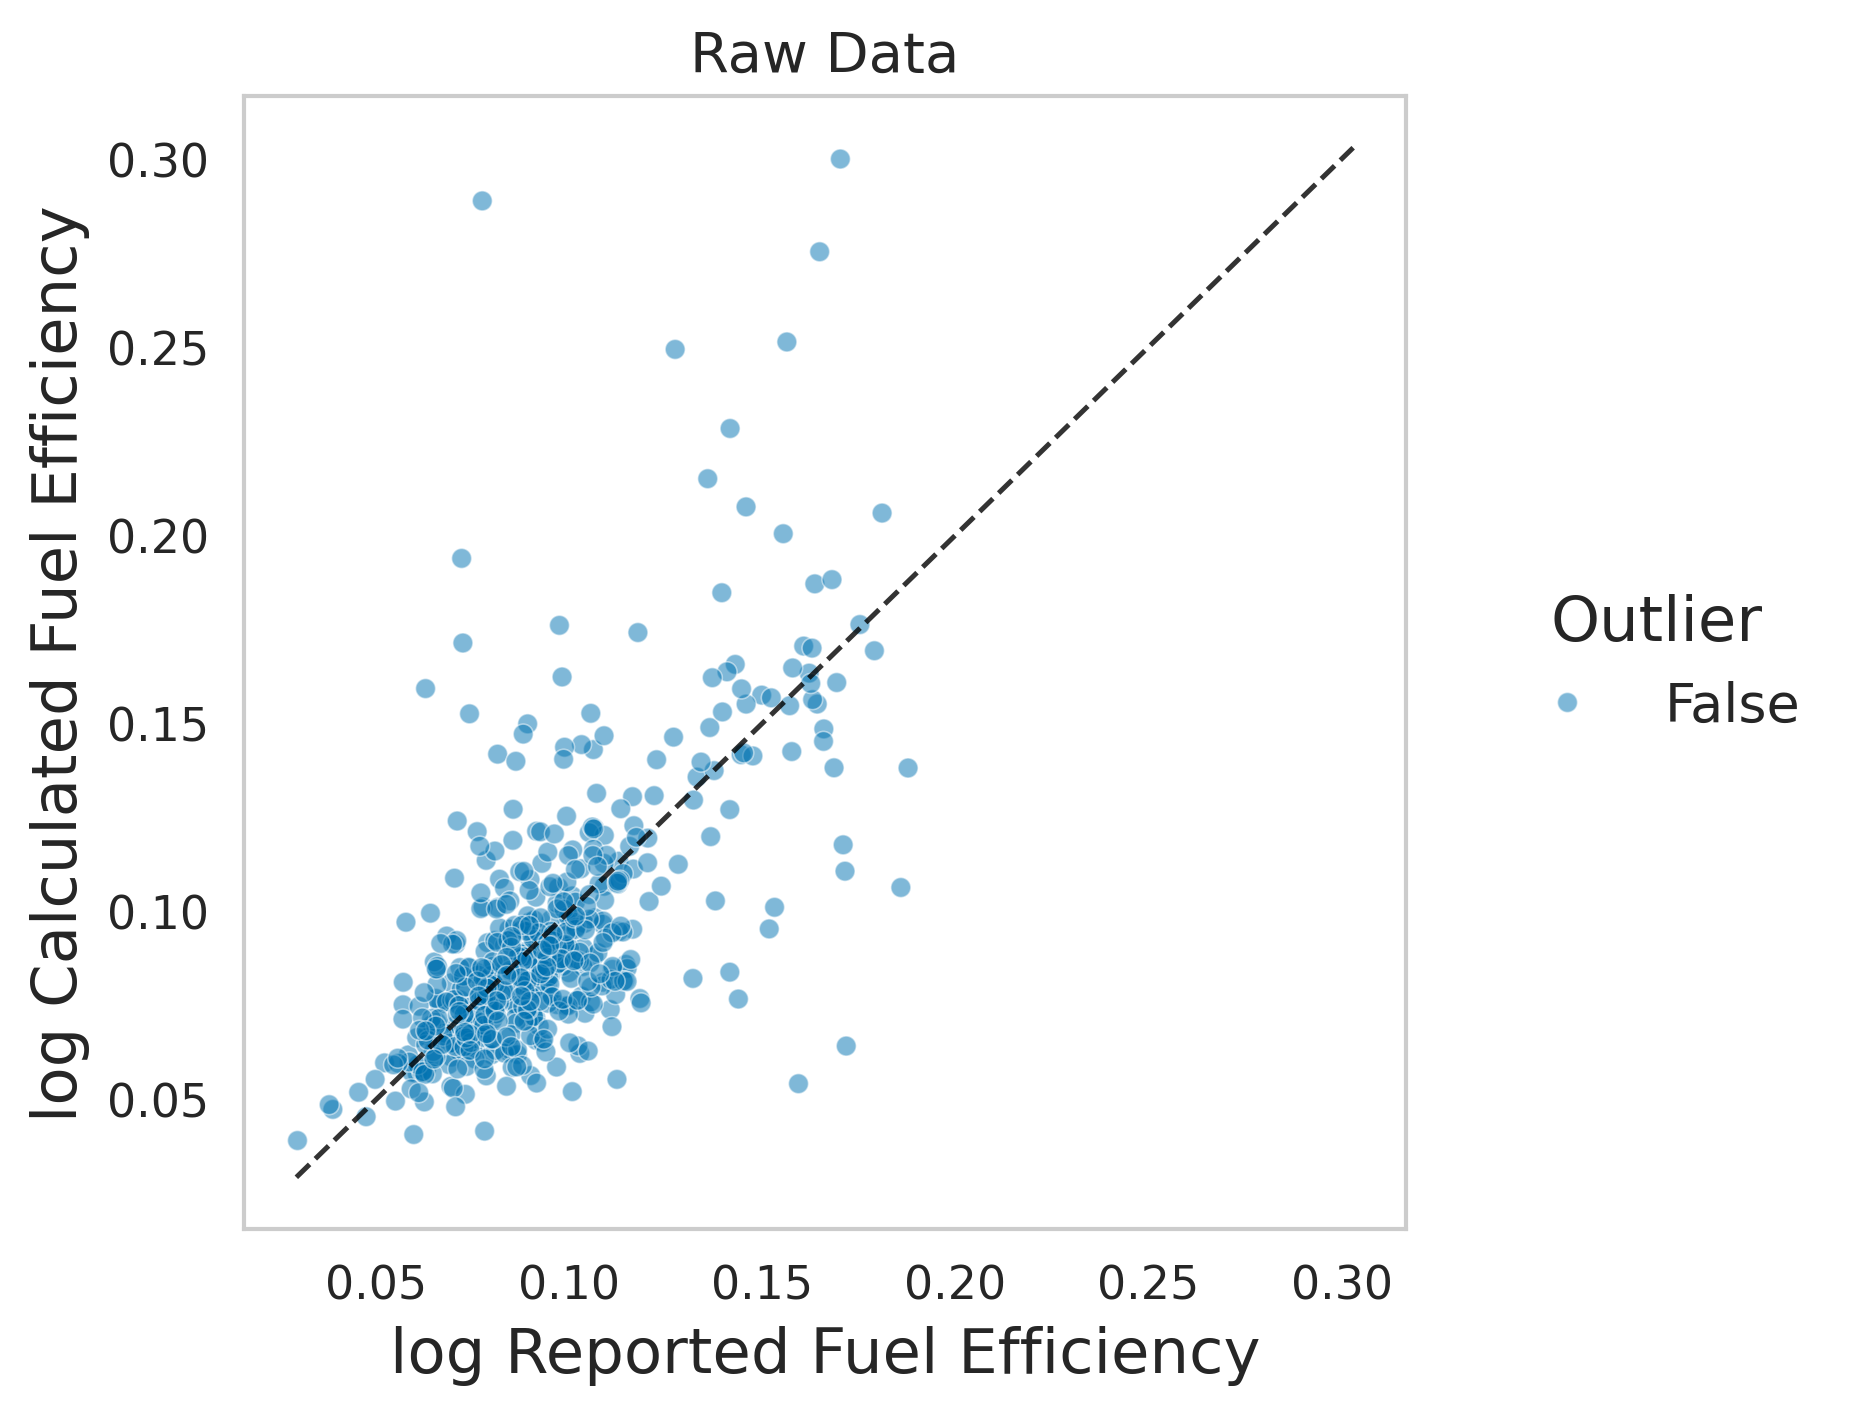

In [22]:
two_way_plot(
     'log_report_target',
     'log_cal_target',
     df_ml,
     hue='outlier',
     title='Raw Data',
     xlabel='log Reported ' + Target_Name,
     ylabel='log Calculated ' + Target_Name,
     legend_title='Outlier',
     regline=False,
     savepath=plotpath + fileprefix + 'twoway_target_raw.png')

<Axes: xlabel='Dwt', ylabel='Proportion'>

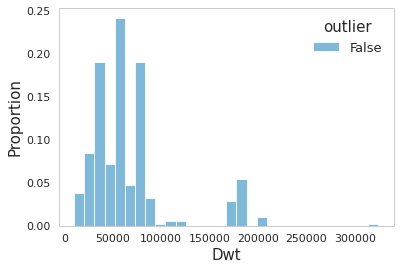

In [23]:
# Compare distributions for a given variable
sns.histplot(data=df_ml, x='Dwt', hue='outlier', stat='proportion', common_norm=False)

In [24]:
# check largest correlates
(
    df_ml
    .corr(numeric_only=True)
    .loc[:, ['outlier']]
    .assign(abs_corr=lambda x: abs(x))
    .sort_values('abs_corr', ascending=False)
    .head(30)
    )


,outlier,abs_corr
CVN,NaN,NaN
imo,NaN,NaN
mmsi,NaN,NaN
Built.Year,NaN,NaN
LDT,NaN,NaN
Demo.Price.LDT,NaN,NaN
Dwt,NaN,NaN
Beam.Mld..m.,NaN,NaN
Draught..m.,NaN,NaN
Price..NB.,NaN,NaN


### Filter out outliers 

In [25]:
df_ml = df_ml.loc[~df_ml['outlier']]
print(f'Filtered Data: \n observations: {len(df_ml)} \n residual mean: {df_ml.residual.mean()} \n residual sd: {df_ml.residual.std()}')

Filtered Data: 
 observations: 535 
 residual mean: 0.018803259108409038 
 residual sd: 0.24850982394191273


In [26]:
df_ml[['report_target', 'cal_target']].describe()

,report_target,cal_target
count,535.000000,535.000000
mean,0.099269,0.098911
std,0.029387,0.039931
min,0.030130,0.039924
25%,0.080360,0.075303
50%,0.094210,0.089093
75%,0.110330,0.108215
max,0.206540,0.349833



#### Scatter plot of reported vs calculated target variable


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


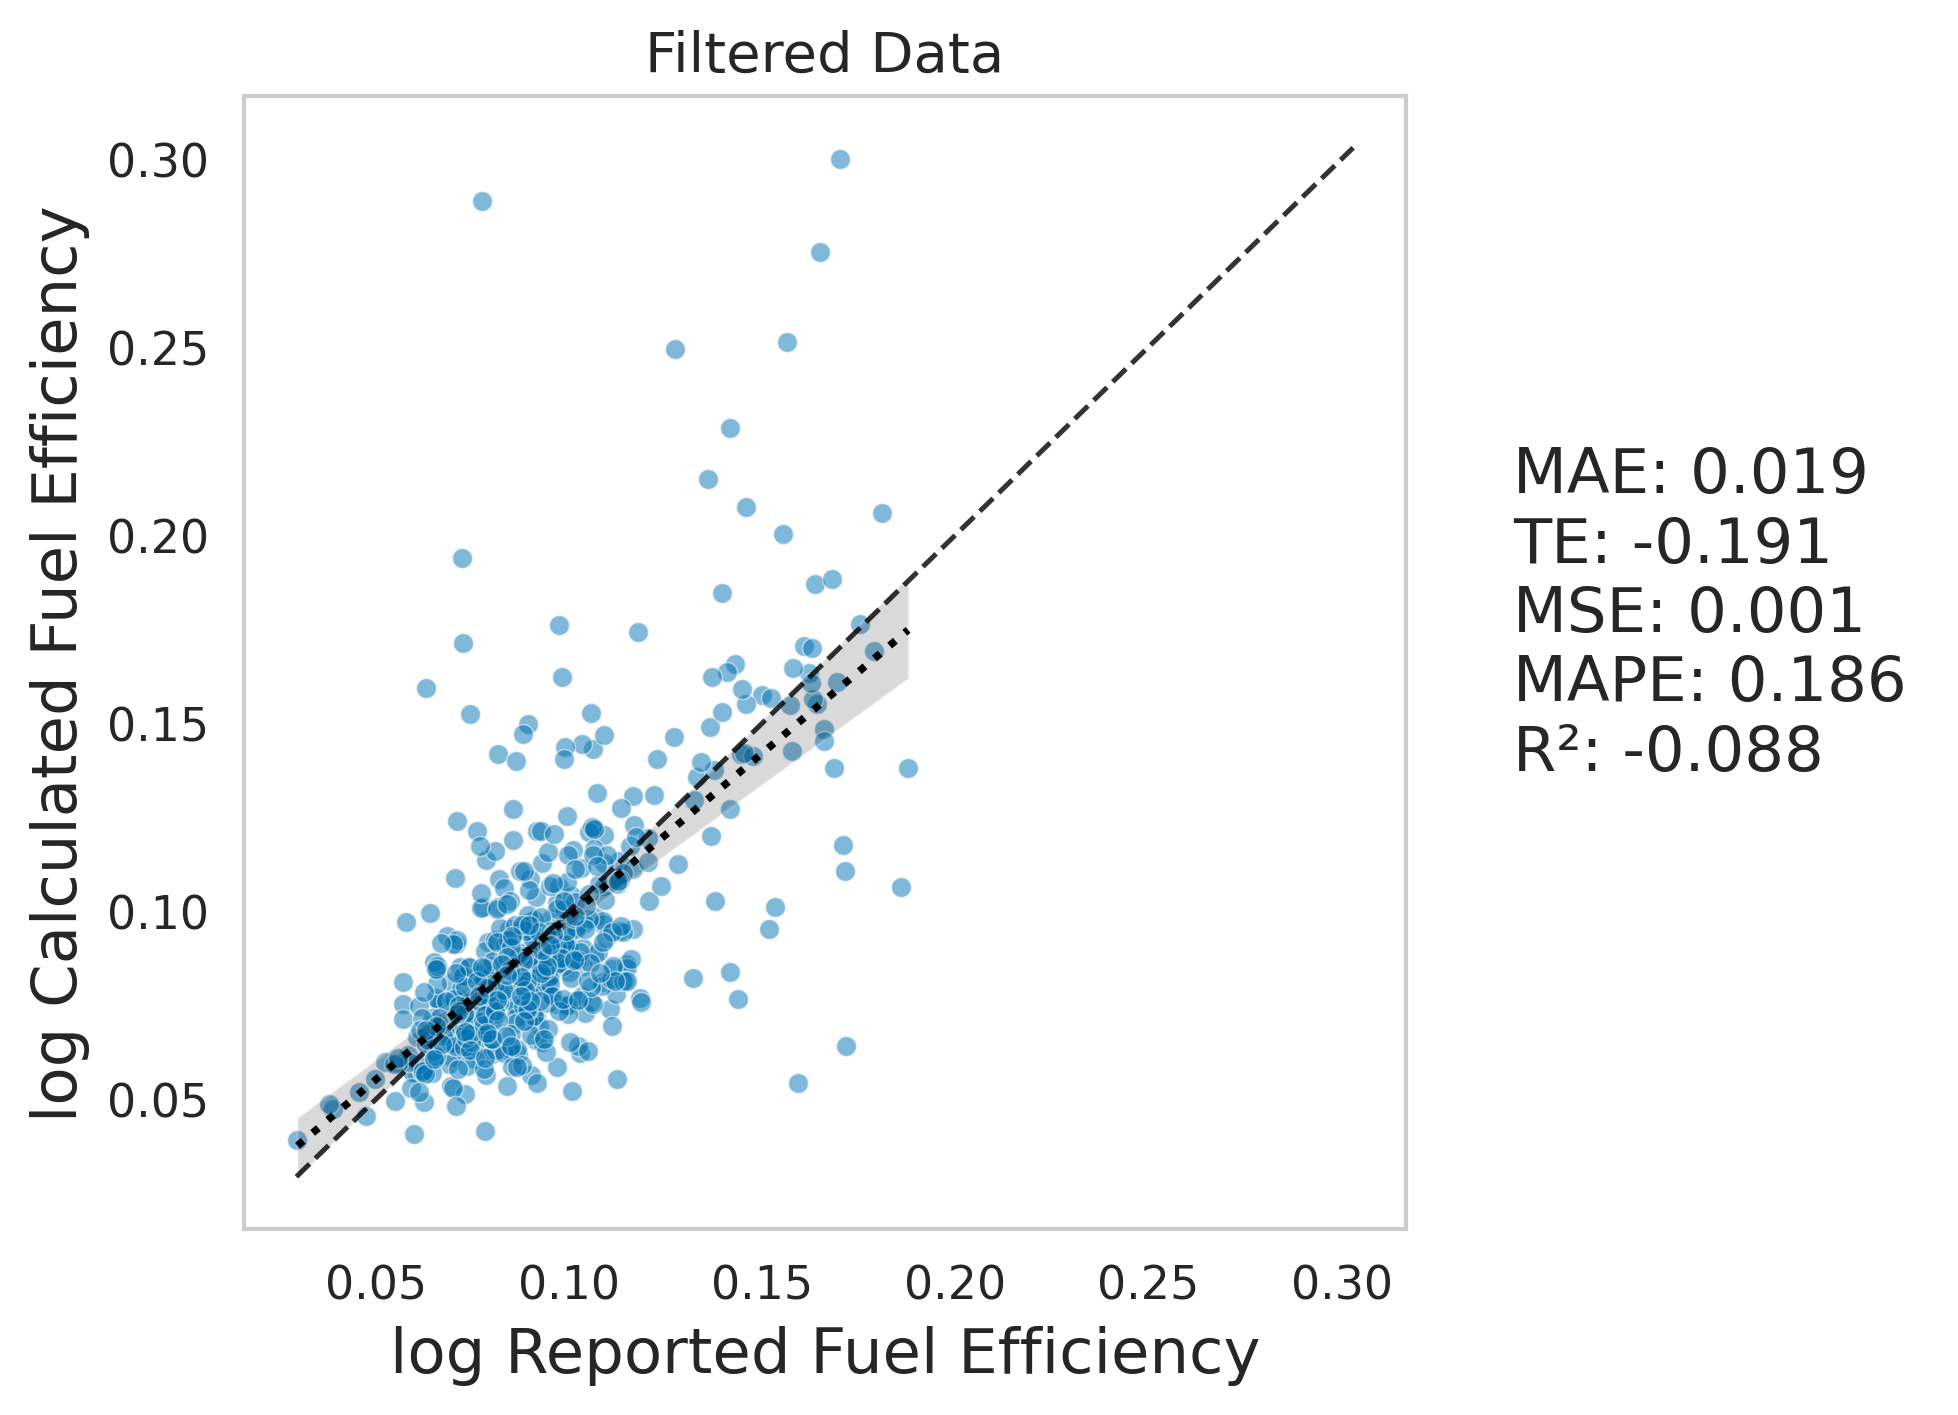

In [27]:
stats_filtered = calculate_stats('report_target', 'cal_target', df_ml, validation_stats)
two_way_plot(
    'log_report_target',
    'log_cal_target',
    df_ml,
    title='Filtered Data',
    xlabel='log Reported ' + Target_Name,
    ylabel='log Calculated ' + Target_Name,
    legend_title=create_legend_title(stats_filtered),
    regline=True,
    savepath=plotpath + fileprefix + 'twoway_target_filtered.png')

#### Scatter plot of reported vs calculated fuel consumption by year

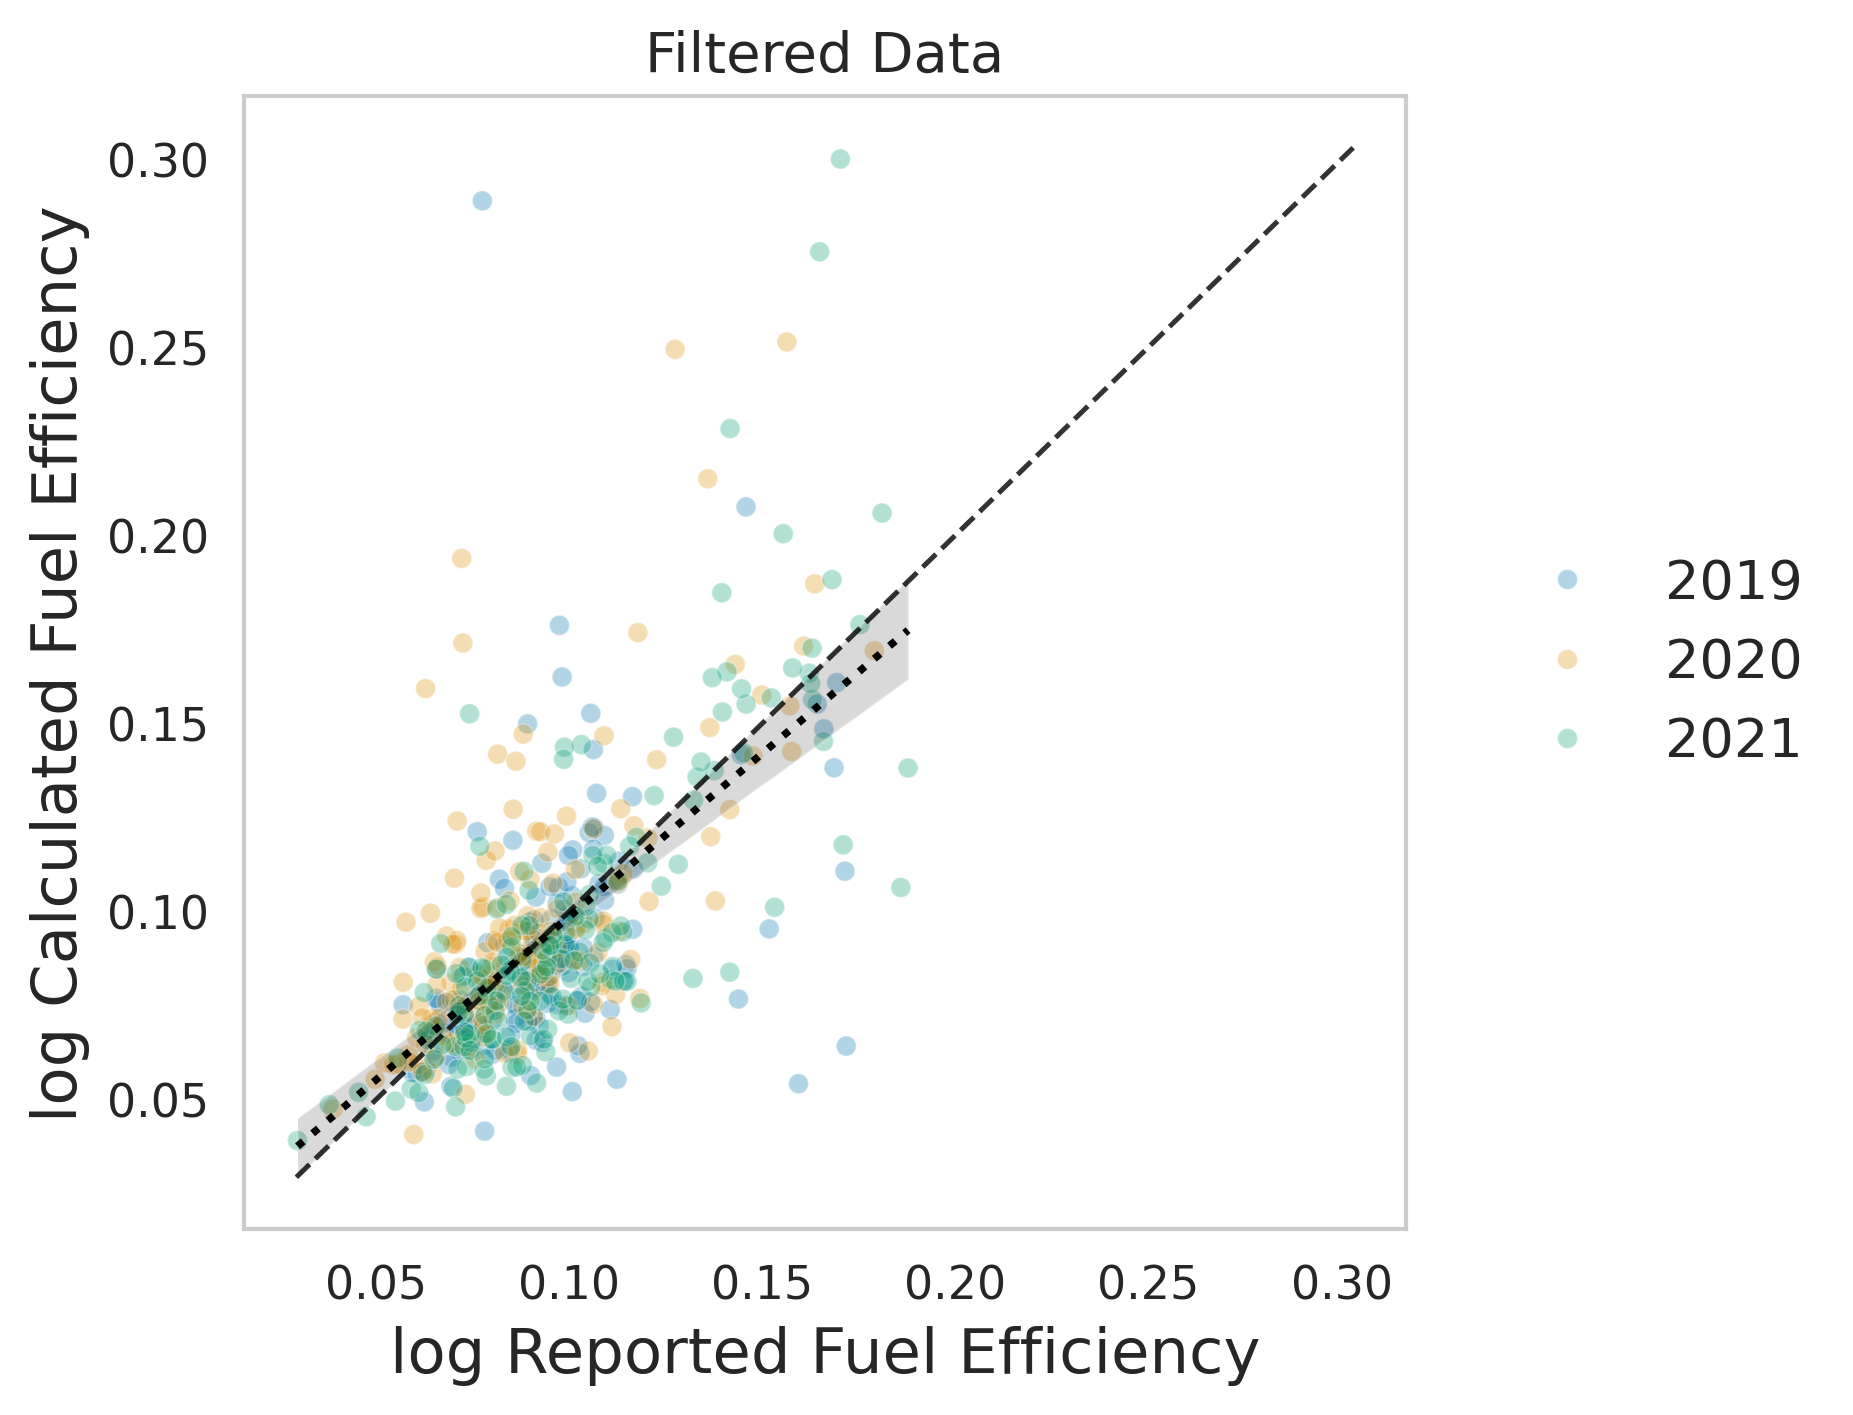

In [28]:
two_way_plot(
    'log_report_target',
    'log_cal_target',
    df_ml,
    hue='year_str',
    alpha=0.3,
    title='Filtered Data',
    xlabel='log Reported ' + Target_Name,
    ylabel='log Calculated ' + Target_Name,
    regline=True,
    savepath=plotpath + fileprefix + 'twoway_targetbyyear_filtered.png')

##### Histogram of target residual (diff of transformed report and cal)

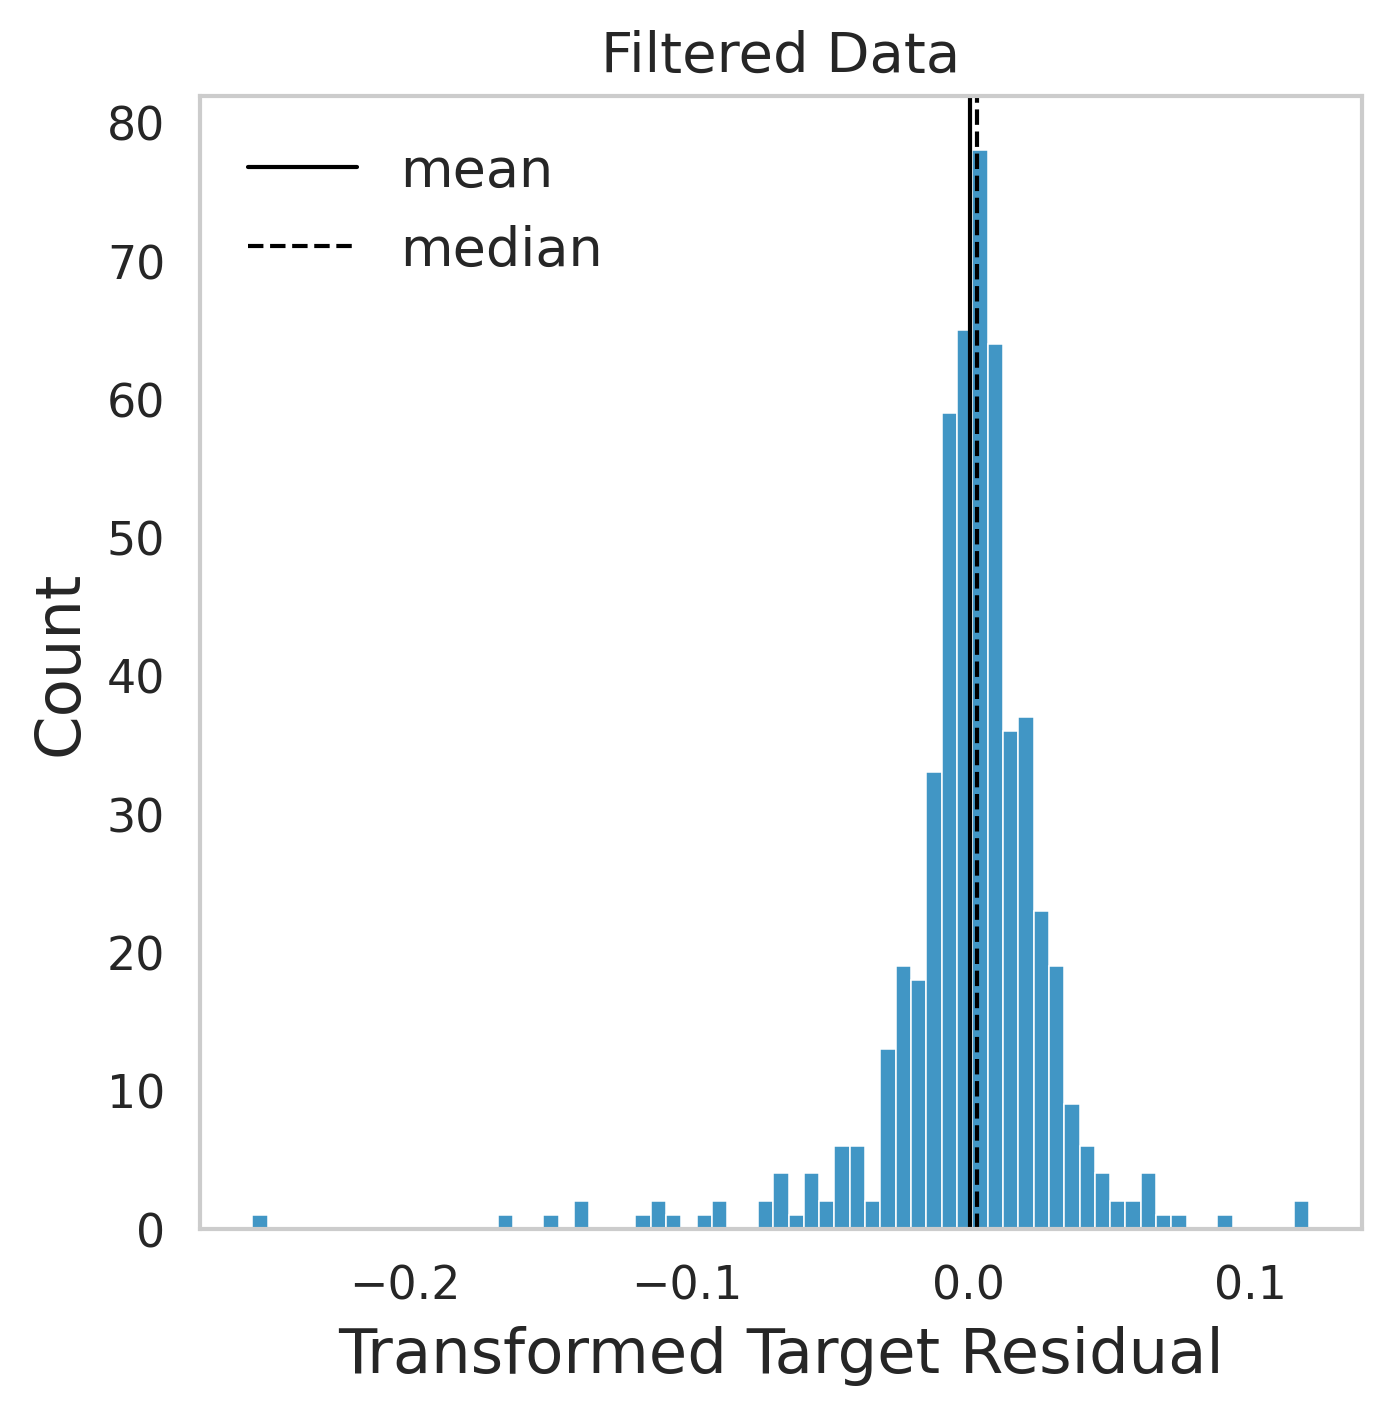

In [29]:
plt.figure(figsize=(5, 5), dpi=300)
sns.histplot(data=df_ml, x='target_residual', kde=False)
plt.title('Filtered Data')
plt.xlabel('Transformed Target Residual')
plt.axvline(df_ml['target_residual'].mean(), color='black', linestyle='solid', linewidth=1, label='mean')
plt.axvline(df_ml['target_residual'].median(), color='black', linestyle='dashed', linewidth=1, label='median')
plt.legend()
plt.savefig(plotpath + fileprefix + 'hist_target_residual_filtered.png')
plt.show()


##### Histogram of target residuals by year

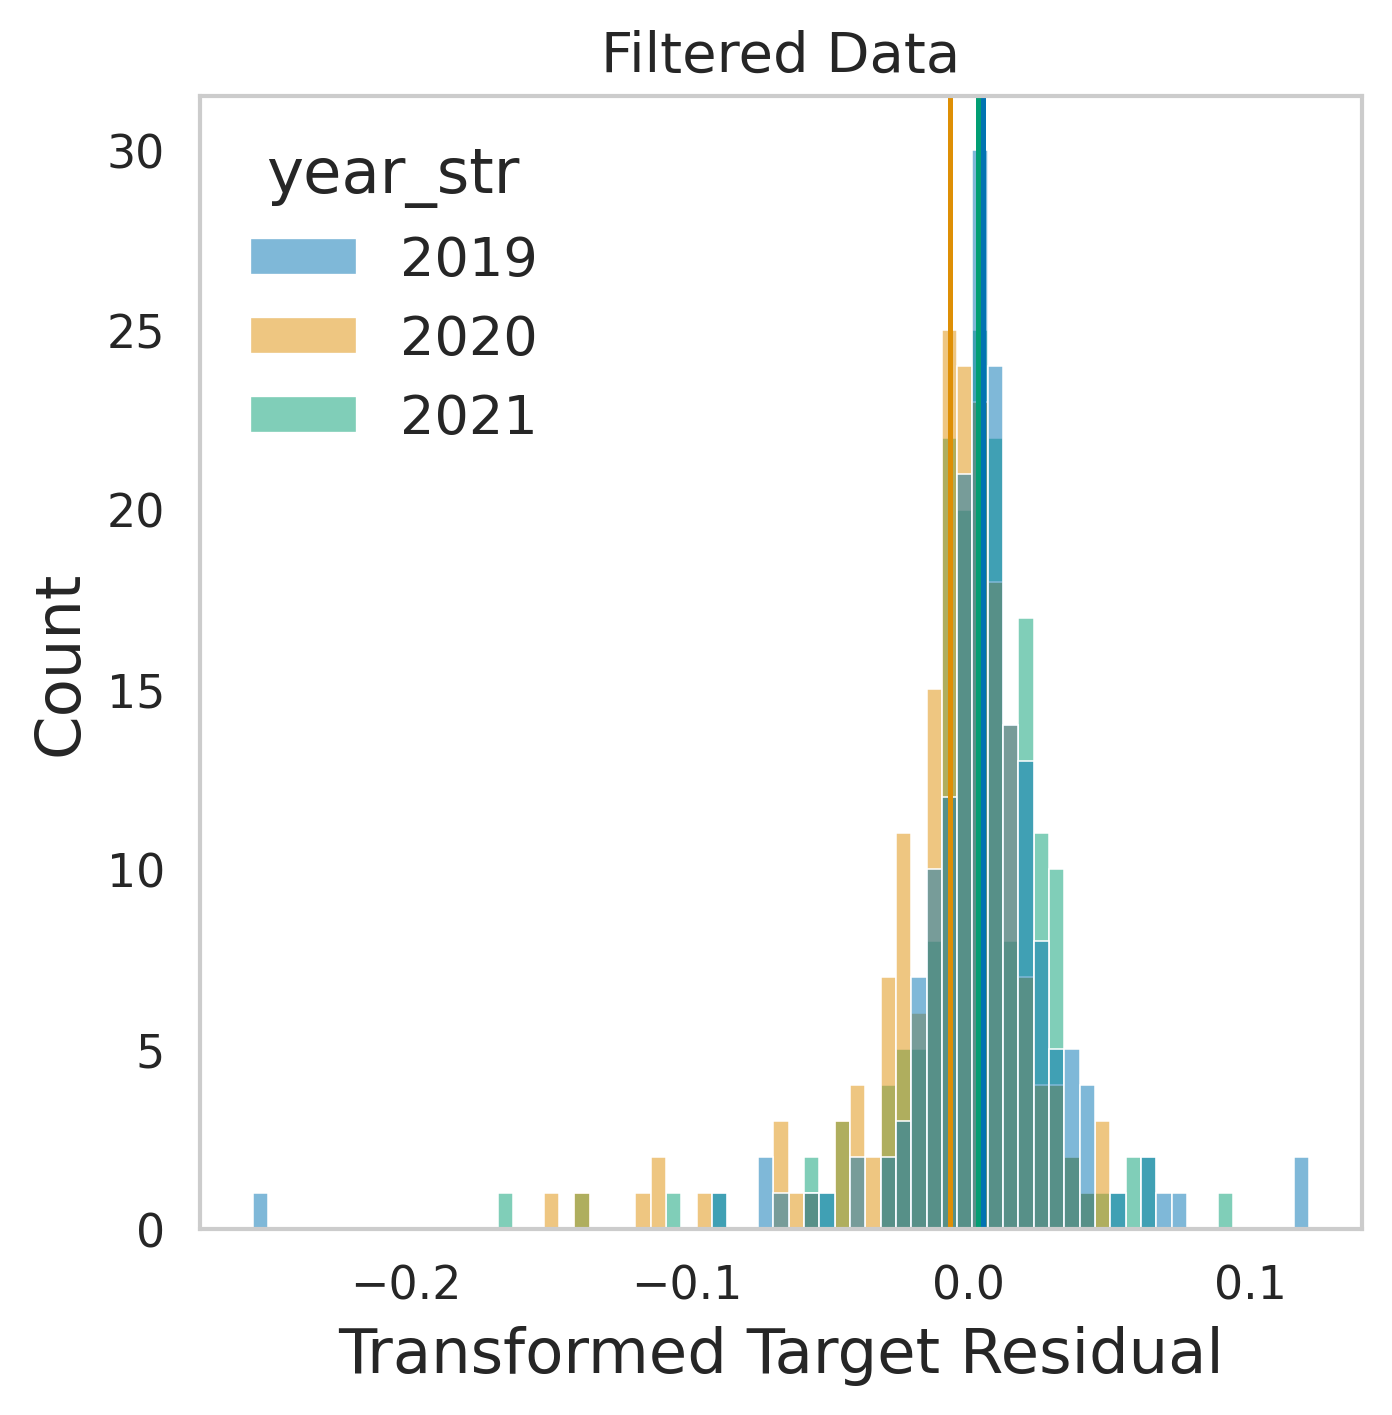

In [30]:
plt.figure(figsize=(5, 5), dpi=300)
sns.histplot(data=df_ml, x='target_residual', hue='year_str', alpha=0.5, kde=False)
hue_values = df_ml['year'].unique()
color_map = dict(zip(hue_values, sns.color_palette()))
for year, color in color_map.items():
    plt.axvline(df_ml[df_ml['year'] == year]['target_residual'].mean(), color=color)
plt.title('Filtered Data')
plt.xlabel('Transformed Target Residual')
plt.savefig(plotpath + fileprefix + 'hist_targetresidualbyyear_filtered_.png')
plt.show()

### Histogram of target

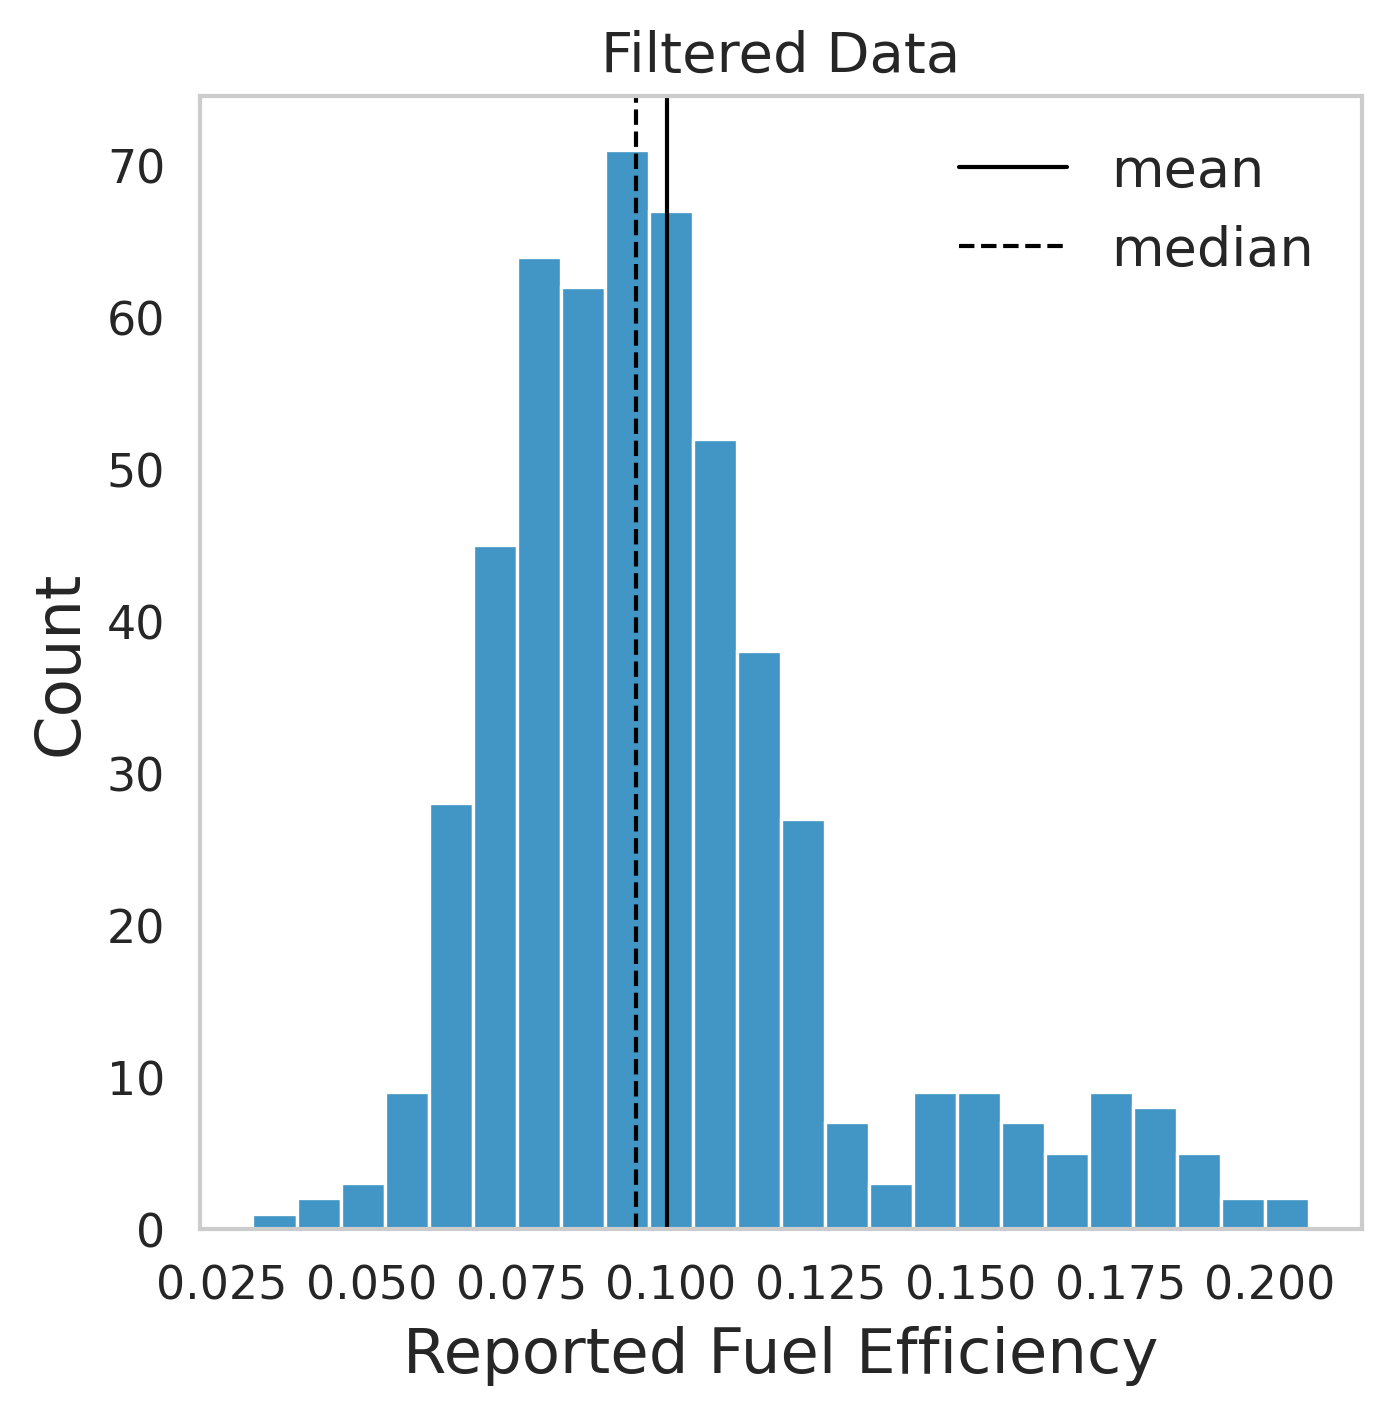

In [31]:
plt.figure(figsize=(5, 5), dpi=300)
sns.histplot(data=df_ml, x='report_target', kde=False)
plt.title('Filtered Data')
plt.xlabel('Reported ' + Target_Name)
plt.axvline(df_ml['report_target'].mean(), color='black', linestyle='solid', linewidth=1, label='mean')
plt.axvline(df_ml['report_target'].median(), color='black', linestyle='dashed', linewidth=1, label='median')
plt.legend()
plt.savefig(plotpath + fileprefix + 'hist_target_filtered.png')
plt.show()

### Histogram of log target

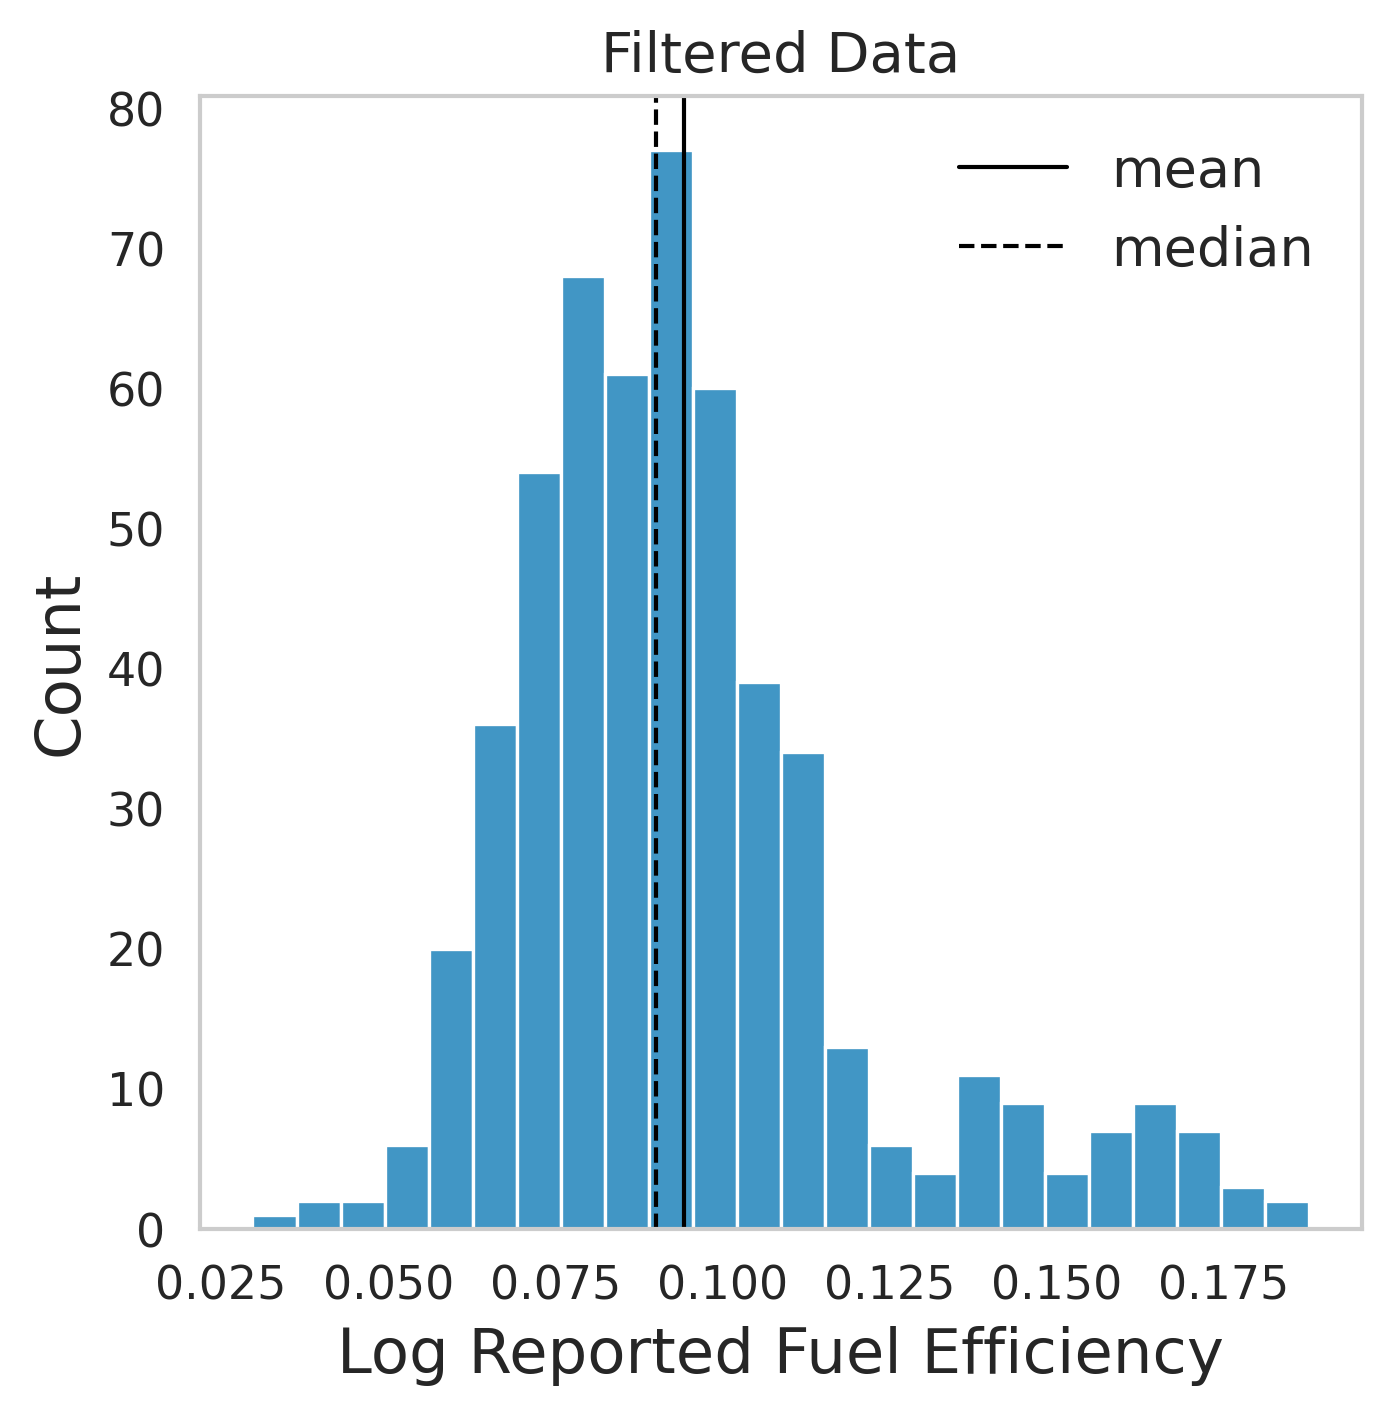

In [32]:
plt.figure(figsize=(5, 5), dpi=300)
sns.histplot(data=df_ml, x='log_report_target', kde=False)
plt.title('Filtered Data')
plt.xlabel('Log Reported ' + Target_Name)
plt.axvline(df_ml['log_report_target'].mean(), color='black', linestyle='solid', linewidth=1, label='mean')
plt.axvline(df_ml['log_report_target'].median(), color='black', linestyle='dashed', linewidth=1, label='median')
plt.legend()
plt.savefig(plotpath + fileprefix + 'hist_logtarget_filtered.png')
plt.show()

## Feature Selection


### Manually Selected Features


In [33]:
# Define category ordering
ordinal_encoding_cat_dict = {
    'Size.Category' : ['Capesize', 'Panamax', 'Handymax', 'Handysize']
}

### Assign feature set

In [34]:
if feature_set in variants:
    features = feature_sets_df.loc[feature_sets_df[feature_set], 'variable'].to_list()
else:
    features = [feature_set]

# Modify FC feature definitions for FE models
if target == 'fe':
    if 'distance_sum' in features:
        features.remove('distance_sum') # because feature list is based on FC variables

    # replace cal_fc with cal_fe if present
    if 'cal_fc' in features:
        index = features.index('cal_fc')
        features[index] = 'cal_fe' 


features_df = pd.read_csv(tablepath + 'ML_FC_Exploration_all_feature_names_desc.csv')

ordinal_cols = features_df.loc[features_df['variable'].isin(features) & (features_df['type'] == 'ordinal'), 'variable'].to_list()
indicator_cols = features_df.loc[features_df['variable'].isin(features) & (features_df['type'] == 'indicator'), 'variable'].to_list()
cat_cols = features_df.loc[features_df['variable'].isin(features) & (features_df['type'] == 'cat'), 'variable'].to_list()
numnonneg_cols = features_df.loc[features_df['variable'].isin(features) & (features_df['type'] == 'numnonneg'), 'variable'].to_list()
numneg_cols = features_df.loc[features_df['variable'].isin(features) & (features_df['type'] == 'numneg'), 'variable'].to_list()
pd.DataFrame(features, columns=['variable']).to_csv(trackeddatapath + fileprefix + 'features.csv', index=False)


if set(ordinal_cols + indicator_cols + cat_cols + numnonneg_cols + numneg_cols) != set(features):
    sys.exit("Variable types undefined. Check 'type' column is correctly specified in 'ML_FC_Exploration_all_feature_names_desc.csv'")

#### Check how many missing for each feature

In [ ]:
missing_frac = df_ml[features].isna().sum()/len(df_ml)
print('Missing Fraction (if non-zero):')
print(missing_frac[missing_frac > 0])

### Set variables for ml training

In [36]:
y = df_ml['report_target']

# need cal_fc in dataset for calculating engineering stats
if 'cal_fc' in features:
    X = df_ml[features]
else:
    X = df_ml[features + ['cal_fc']]

#### Collinearity

In [ ]:
groups_df = features_df[['variable', 'group']]
corr_mx = (
    X[numneg_cols + numnonneg_cols]
    .corr()

)

corr_mx = (
    corr_mx
    .merge(groups_df[['variable', 'group']], left_index=True, right_on='variable')
    .sort_values('group')
    .drop(columns='group')
    .set_index('variable'))
corr_mx = corr_mx[corr_mx.index]
print(corr_mx)
plt.figure(figsize=(10, 10), dpi=300)
sns.heatmap(corr_mx, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of X')
plt.show()


## Models

In [ ]:
mdl_df = tribble(
    ['model',    'class_name',                 'name',                    'type',  'scaling', 'fast'],
     'gb',       'GradientBoostingRegressor',  'Gradient Boosting',       'tree',   False,    True,
     'linear',   'LinearRegression',           'Linear Regression',       'linear', False,    True,
     'lasso',    'Lasso',                      'Lasso',                   'linear', True,     True,
     'ridge',    'Ridge',                      'Ridge',                   'linear', True,     True,
     'rf',       'RandomForestRegressor',      'Random Forest',           'tree',   False,    False,
     'cb',       'CatBoostRegressor',          'Cat Boost',               'tree',   False,    False
    #  'lgbm',     'LGBMRegressor',              'Light Gradient Boosting', 'tree',   False,
    #  'xgb',      'XGBRegressor',           'tree',   False,
).set_index('model')
if fast_only:
    mdl_df = mdl_df[mdl_df['fast']]

mdl_df.to_csv(trackeddatapath + fileprefix + 'mdl_settings.csv')
mdl_df

## Pre-processing

### Imputation, Tranformation, Scaling

In [39]:
median_imputer = SimpleImputer(strategy='median')
missing_string = 'missing'
impute_as_missing = SimpleImputer(strategy='constant', fill_value=missing_string)

# setting categories manually is necessary for prediction in using the kfold evaluation loop
ind_to_encode = [X[col].fillna('missing').unique() for col in indicator_cols]
ind_encoder = OneHotEncoder(categories=ind_to_encode)
ind_encoder_nonregularized = OneHotEncoder(categories=ind_to_encode, drop='first')

cat_to_encode = [X[col].fillna('missing').unique() for col in cat_cols]
cat_encoder = OneHotEncoder(categories=cat_to_encode)
cat_encoder_nonregularized = OneHotEncoder(categories=cat_to_encode, drop='first')

log_transformer = FunctionTransformer(np.log1p, validate=True)
ordinal_transformer = make_pipeline(OrdinalEncoder(categories=[values for values in ordinal_encoding_cat_dict.values()]))

scaler = StandardScaler()

# Pipelines for numerical
impute = Pipeline(steps=[('impute', median_imputer)])

impute_transform = Pipeline(steps=[
    ('impute', median_imputer),
    ('transform', log_transformer)])

impute_scale = Pipeline(steps=[
    ('impute', median_imputer),
    ('scale', scaler)])

impute_transform_scale = Pipeline(steps=[
    ('impute', median_imputer),
    ('transform', log_transformer),
    ('scale', scaler)])

# Pipelines for indicator
ind_impute_encode = Pipeline(steps=[
    ('impute', impute_as_missing),
    ('encode', ind_encoder)])

ind_impute_encode_nonregularized = Pipeline(steps=[
    ('impute', impute_as_missing),
    ('encode', ind_encoder_nonregularized)])

# Pipelines for categorical
cat_impute_encode = Pipeline(steps=[
    ('impute', impute_as_missing),
    ('encode', cat_encoder)])

cat_impute_encode_nonregularized = Pipeline(
    steps=[('impute', impute_as_missing),
           ('encode', cat_encoder_nonregularized)])

### Column Transformers

In [40]:
# re-define pipelines if no_transform variant
if no_transform:
    impute_transform_scale = impute_scale
    impute_transform = impute

# scaling not required for tree-based models
preprocessor_scaling = ColumnTransformer(
    transformers=[
        ('numeric_nonneg', impute_transform_scale, numnonneg_cols),
        ('numeric_neg', impute_scale, numneg_cols),
        ('ordinal', ordinal_transformer, ordinal_cols),
        ('indicator', ind_impute_encode, indicator_cols),
        ('categorical', cat_impute_encode, cat_cols)
        ])

preprocessor_noscaling = ColumnTransformer(
    transformers=[
        ('numeric_nonneg', impute_transform, numnonneg_cols), # or with scaling
        ('numeric_neg', impute, numneg_cols), # or with scaling
        ('ordinal', ordinal_transformer, ordinal_cols),
        ('indicator', ind_impute_encode, indicator_cols),
        ('categorical', cat_impute_encode, cat_cols)
        ])

# drops one category of onehot encoded categorical variables (only used for linreg)
preprocessor_noscaling_drop = ColumnTransformer(
    transformers=[
        ('numeric_nonneg', impute_transform, numnonneg_cols), # or with scaling
        ('numeric_neg', impute, numneg_cols), # or with scaling
        ('ordinal', ordinal_transformer, ordinal_cols),
        ('indicator', ind_impute_encode_nonregularized, indicator_cols),
        ('categorical', cat_impute_encode_nonregularized, cat_cols)
        ])


### Check pre-processing visually


#### Plot histograms of processed variables


In [41]:
# TODO: apply columntransformer to X and y
# df_transformed = pd.DataFrame(mdl_gb_original[0].transform(X),
#                               columns = features_m1)
# # %%
# col_to_plot = features_m1[23]
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].hist(df_ml_train[col_to_plot])
# ax[0].axvline(df_ml_train[col_to_plot].median(), color='black', linestyle='solid', linewidth=1, label='mean')
# ax[0].set_title('Original')
# ax[1].hist(df_transformed[col_to_plot])
# ax[1].axvline(df_transformed[col_to_plot].median(), color='black', linestyle='solid', linewidth=1, label='mean')
# ax[1].set_title('Imputed & Transformed')
# fig.suptitle(col_to_plot)
# plt.show()

### Check encoding

In [42]:
# preprocessor_test = ColumnTransformer(
#     transformers=[
#         # ('indicator', ind_impute_encode, indicator_cols),
#         # ('categorical', cat_impute_encode, cat_cols),
#         ('indicator', ind_impute_encode_nonregularized, indicator_cols),
#         ('categorical', cat_impute_encode_nonregularized, cat_cols)
#         ],
#     sparse_threshold=0)

# transform_test = pd.DataFrame(
#     preprocessor_test.fit_transform(df_ml[indicator_cols + cat_cols]),
#     columns=preprocessor_test.get_feature_names_out())
# transform_test.loc[:, transform_test.columns.str.contains('.a')].head()

In [43]:
# df_ml.loc[:, indicator_cols + cat_cols]

### Base Parameters

In [44]:
mdl_base_dict = {
    'gb': {
        'n_estimators': 2000,
        'learning_rate': 0.1,
        'max_depth': 3,
        'max_features': 'sqrt',
        'min_samples_leaf': 20,
        'loss': 'squared_error',
        'min_samples_split': 20,
        'warm_start': True
    },
    'linear': {},
    'lasso': {
        'alpha': 0.01,
    },
    'ridge': {
        'alpha': 0.01,
    },
    'rf': {
        'n_estimators': 200,
        'max_depth': 10,
        # 'max_features': 'sqrt',
        # 'min_samples_leaf': 20,
        # 'min_samples_split': 20,
    },
    'cb': {
        'verbose': 0
    },
    'lgbm': {
        'verbose': 1
    },
    'xgb': {} 
}


mdl_df['base_params'] = [mdl_base_dict.get(mdl) for mdl in mdl_df.index]

## Estimators

In [45]:
mdl_df['estimator'] = mdl_df.apply(
    lambda row: make_estimator(
        row['scaling'],
        row['class_name'],
        y_transformer_func=y_transformer_func,
        y_transformer_inverse_func=y_transformer_inverse_func,
        random_seed=random_seed,
        params=row['base_params']),
    axis=1)

## Test base parameters

In [46]:
for model in mdl_df.index:
    mdl_df.loc[model, 'estimator'].fit(X, y)

#### Target

In [ ]:
mdl_df['base_target_stats'] = mdl_df.apply(
    lambda row: calculate_stats(
        y,
        row['estimator'].predict(X),
        stats_dict=validation_stats),
    axis=1)

compare_base_target_df = model_stats_comparison_table('base_target_stats', 'base_params', 'estimator', mdl_df).sort_values(scoring, ascending=not validation_stats[scoring][2])
compare_base_target_df.to_csv(trackeddatapath + fileprefix + 'base_target.csv')
compare_base_target_df

In [48]:
mdl_df.to_pickle(datapath + fileprefix + model_df_filename + '_base.pkl')

In [ ]:
print(f"Test base parameters complete at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))}, after {round((time.time() - start_time)/60, 1)} minutes")


## Hyperparameter Tuning: 5-fold CV, Grid Search

In [50]:
mdl_df = pd.read_pickle(datapath + fileprefix + model_df_filename + '_base.pkl')

### Define search grids

In [51]:
mdl_gs_dict = {
    'gb': {
        'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 4, 5, 6]
    },
    'linear': {},
    'lasso': {
        'alpha': [5e-3, 1e-2, 0.1, 1, 10, 100, 1000],
    },
    'ridge': {
        'alpha': [5e-3, 1e-2, 0.1, 1, 10, 100, 1000, 10000, 100000],
    },
    'rf': {
        'n_estimators': [200, 700, 1000],
        'max_depth': [10, 30, 50],
        # 'max_features': ['sqrt'],
        # 'min_samples_leaf': [20],
        # 'min_samples_split': [20],
    },
    'cb': {
        'learning_rate' : [0.01, 0.05, 0.1],
        'depth': [6, 8 ,10],
        # 'iterations': [10, 50, 500],
        'l2_leaf_reg': [1, 7, 15]
    },
    'lgbm': {
        'num_leaves': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        'learning_rate': [0.005, 0.01, 0.1, 0.2, 0.3],
        'num_iterations': [10, 50, 100, 500, 1000, 5000, 10000],
        'max_bin': [255, 300, 500, 1000],
        'boosting' : ['gbdt', 'dart'],
    },
    # 'xgb': 
}


mdl_df['gs_params'] = [mdl_gs_dict.get(mdl) for mdl in mdl_df.index]

In [52]:
# for quicker testing
# mdl_gs_dict = {
#     'gb': {
#         'learning_rate': [0.01],
#         'max_depth': [3, 4]
#     },
#     'linear': {},
#     'lasso': {
#         'alpha': [0.1],
#     },
#     'ridge': {
#         'alpha': [0.1],
#     },
#     'rf': {
#         'n_estimators': [200],
#         'max_depth': [10],
#         # 'max_features': ['sqrt'],
#         # 'min_samples_leaf': [20],
#         # 'min_samples_split': [20],
#     },
#     'cb': {
#         'depth': [6, 8],
#         'iterations': [30],
#         'l2_leaf_reg': [7]
#     },
#     'lgbm': {
#         'num_leaves': [50],
#         'learning_rate': [0.01, 0.1],
#         'num_iterations': [100],
#         'max_bin': [500],
#         'boosting' : ['gbdt', 'dart']
#     },
#     # 'xgb': 
# }


# mdl_df['gs_params'] = [mdl_gs_dict.get(mdl) for mdl in mdl_df.index]

In [ ]:
# add model class_name prefix to parameter names
mdl_df['gs_params_prefix'] = mdl_df.apply(lambda row: {'regressor__' + row['class_name'].lower() + '__' + k: v for k, v in row['gs_params'].items()}, axis=1)
mdl_df[['gs_params', 'gs_params_prefix']]

### Fit grid search

In [ ]:
mdl_df['grid_search'] = mdl_df.apply(
    lambda row: GridSearchCV(
        row['estimator'],
        row['gs_params_prefix'],
        cv=cv_folds,
        scoring=cv_scoring,
        n_jobs=max_cores,
        verbose=1),
        axis=1)

for model in mdl_df.index:
    mdl_df.loc[model, 'grid_search'].fit(X, y)
    
mdl_df['best_estimator'] = mdl_df.apply(lambda row: row['grid_search'].best_estimator_, axis=1)
# This estimator is refitted on whole training set

# Column of best parameters chosen from grid search CV (with short names)
mdl_df['best_params'] = mdl_df.apply(lambda row: extract_filter_params(row, 'best_estimator', 'gs_params'), axis=1)


### CV Results

In [ ]:
mdl_df['best_cv_mean_score'] = mdl_df.apply(lambda row: row['grid_search'].cv_results_['mean_test_score'][row['grid_search'].best_index_], axis=1)

mdl_df['best_cv_std_score'] = mdl_df.apply(lambda row: row['grid_search'].cv_results_['std_test_score'][row['grid_search'].best_index_], axis=1)

cv_best_target = (
    mdl_df.loc[:, ['class_name', 'best_cv_mean_score', 'best_cv_std_score', 'best_params']]
    .sort_values('best_cv_mean_score', ascending=False)
    )
cv_best_target.to_csv(trackeddatapath + fileprefix + 'best_cv_target.csv')
cv_best_target

### Best estimator training set stats

In [ ]:
mdl_df['best_target_stats'] = mdl_df.apply(
    lambda row: calculate_stats(
        y,
        row['best_estimator'].predict(X),
        stats_dict=validation_stats),
    axis=1)
compare_best_target_df = model_stats_comparison_table('best_target_stats', 'best_params', 'best_estimator', mdl_df).sort_values(scoring, ascending=not validation_stats[scoring][2])
compare_best_target_df.to_csv(trackeddatapath + fileprefix + 'best_train_target.csv')
compare_best_target_df

In [57]:
mdl_df.to_pickle(datapath + fileprefix + model_df_filename + '_best.pkl')

In [ ]:
print(f"Hyperparameter tuning complete at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))}, after {round((time.time() - start_time)/60, 1)} minutes")

#### Run time
- takes around 25 minutes total

In [ ]:
# processing time (seconds) of best estimators
mdl_df.loc[:, 'grid_search'].apply(lambda x: x.cv_results_['mean_fit_time'][x.cv_results_['rank_test_score'] == 1][0])

## Evaluation of Tuned Models


In [60]:
mdl_df = pd.read_pickle(datapath + fileprefix + model_df_filename + '_best.pkl')

In [61]:
mdl_df['eval_stats'] = mdl_df.apply(
    lambda row: cross_validate_stats(
        X,
        y,
        row['best_estimator'],
        eval_types_dict[train_eval_type],
        validation_stats,
        max_cores),
    axis=1)

### Stats target

In [ ]:
eval_means_df = model_stats_comparison_table('eval_stats', 'best_params', 'best_estimator', mdl_df, 'means')
eval_sds_df = model_stats_comparison_table('eval_stats', 'best_params', 'best_estimator', mdl_df, 'sds')
compare_eval_df = eval_means_df.join(
    eval_sds_df.drop(columns=['class_name', 'params']),
    lsuffix='_mean',
    rsuffix='_sd').sort_values('r2_mean', ascending=False)
compare_eval_df.to_csv(trackeddatapath + fileprefix + 'eval_target_stats.csv')
compare_eval_df

In [ ]:
mdl_df.to_pickle(datapath + fileprefix + model_df_filename + '_eval.pkl')

print(f"Training set evaluation complete at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))}, after {round((time.time() - start_time)/60, 1)} minutes")

## Training Set Performance

In [64]:
mdl_df = pd.read_pickle(datapath + fileprefix + model_df_filename + '_eval.pkl')

### Calculated Fuel Consumption

In [ ]:
stats_eng = calculate_stats(y, X.cal_fc, stats_dict=validation_stats)
stats_eng_df = pd.DataFrame(stats_eng).drop('names', axis=1).T
stats_eng_df['model'] = 'eng'
stats_eng_df['class_name'] = 'Calculation'
stats_eng_df = stats_eng_df.set_index('model')
stats_eng_df

### Stats target

#### ML Models

In [66]:
for model in mdl_df.index:
    mdl_df.loc[model, 'best_estimator'].fit(X, y)

In [ ]:
mdl_df['train_prediction'] = mdl_df.apply(lambda row: row['best_estimator'].predict(X), axis=1)
mdl_df['train_target_stats'] = mdl_df.apply(
    lambda row: calculate_stats(
        y,
        row['train_prediction'],
        stats_dict=validation_stats),
    axis=1)
compare_train_target_df = model_stats_comparison_table('train_target_stats', 'best_params', 'best_estimator', mdl_df)
if target == 'fc':
    compare_train_target_df = pd.concat([stats_eng_df, compare_train_target_df], axis=0).sort_values(scoring, ascending=not validation_stats[scoring][2])
compare_train_target_df.to_csv(trackeddatapath + fileprefix + 'train_target.csv', index=True)
compare_train_target_df

### Two-way plot of target

In [ ]:
mdl_df.apply(lambda row: two_way_plot(y, row['train_prediction'], title=row['name'], xlabel='True ' + Target_Name, ylabel='Predicted ' + Target_Name, regline=True, legend=False), axis=1)

In [ ]:
print(f"Evaluation complete at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))}, after {round((time.time() - start_time)/60, 1)} minutes")

### Stats Fuel Consumption

In [ ]:
if target == 'fe':
    mdl_df['train_fc_stats'] = mdl_df.apply(
        lambda row: calculate_stats(
            df_ml.report_fc,
            row['train_prediction']*df_ml['distance_sum'],
            stats_dict=validation_stats),
        axis=1)
    compare_train_fc_df = model_stats_comparison_table('train_fc_stats', 'best_params', 'best_estimator', mdl_df)
    compare_train_fc_df = pd.concat([stats_eng_df, compare_train_fc_df], axis=0).sort_values('r2', ascending=False)

    compare_train_fc_df.to_csv(trackeddatapath + fileprefix + 'train_fc.csv')
    print(compare_train_fc_df)

## Test Data

### Load, explore, filter

In [ ]:
# df_ml_test = pd.read_csv(readdatapath + "df_ml_" + tol_type + "_test.csv", low_memory=False)
df_ml_test = df_ml_raw.loc[eval(test_exp)]

# for nicer colors when plotting
df_ml_test = df_ml_test.sort_values('year')
df_ml_test['year_str'] = df_ml_test['year'].astype(str) 

# efficiency target variable
df_ml_test['report_fe'] = df_ml_test['report_fc'] / df_ml_test['MRV.EU.distance']
df_ml_test['log_report_fe'] = np.log1p(df_ml_test['report_fe'])
df_ml_test['cal_fe'] = df_ml_test['cal_fc'] / df_ml_test['distance_sum']
df_ml_test['log_cal_fe'] = np.log1p(df_ml_test['cal_fe'])

# OECD variable
df_ml_test['cubic_meter'] = df_ml_test['Beam.Mld..m.']*df_ml_test['Depth.Moulded..m.']*df_ml_test['LOA..m.']

# Set target variable
df_ml_test['report_target'] = df_ml_test['report_' + target]
df_ml_test['cal_target'] = df_ml_test['cal_' + target]
df_ml_test['log_report_target'] = np.log1p(df_ml_test['report_' + target])
df_ml_test['log_cal_target'] = np.log1p(df_ml_test['cal_' + target])
if no_transform:
    df_ml_test['target_residual'] = df_ml_test['report_target'] - df_ml_test['cal_target']
else:
    df_ml_test['target_residual'] = y_transformer_func(df_ml_test['report_target']) - y_transformer_func(df_ml_test['cal_target'])

# Label as outliers according *training* set thresholds
df_ml_test['outlier'] = ~df_ml_test['residual'].between(
    raw_mean - outlier_threshold * raw_std,
    raw_mean + outlier_threshold * raw_std,
    inclusive='neither')

df_ml_test.describe(include='all')

In [ ]:
df_ml_test['outlier'].value_counts()

### Plot raw vs. training

In [ ]:
two_way_plot(
     'log_report_target',
     'log_cal_target',
     df_ml_test,
     hue='outlier',
     title='Raw Test Data',
     xlabel='log Reported ' + Target_Name,
     ylabel='log Calculated ' + Target_Name,
     legend_title='Outlier',
     regline=False)
    #  savepath=plotpath + fileprefix + 'twoway_target_raw.png')

#### Histogram by outlier

In [ ]:
print(raw_mean - outlier_threshold * raw_std)
print(raw_mean + outlier_threshold * raw_std)

In [ ]:
plt.figure(figsize=(5, 5), dpi=300)
sns.histplot(data=df_ml_test, x='residual', hue='outlier', alpha=0.5, kde=False)
hue_values = df_ml['year'].unique()
color_map = dict(zip(hue_values, sns.color_palette()))
for year, color in color_map.items():
    plt.axvline(df_ml[df_ml['year'] == year]['residual'].mean(), color=color)
plt.title('Test Data Residual')
plt.xlabel('Residual')
# plt.savefig(plotpath + fileprefix + 'hist_residualbyyear_filtered_.png')
plt.show()

In [ ]:
df_ml_test = df_ml_test.loc[~df_ml_test['outlier']]
print(f'Filtered Data: \n observations: {len(df_ml)} \n residual mean: {df_ml_test.residual.mean()} \n residual sd: {df_ml_test.residual.std()}')

### Plot all data

In [77]:
df_ml_all = pd.concat([df_ml, df_ml_test], keys=['Training', 'Test'])
df_ml_all.reset_index(level=0, inplace=True)
df_ml_all.rename(columns={'level_0': 'dataset'}, inplace=True)

In [ ]:
df_ml_all[['report_target', 'cal_target']].agg(['count', 'mean', 'std']).to_csv(trackeddatapath + fileprefix + 'desc_stats_filtered_all.csv')
df_ml_all[['report_target', 'cal_target']].agg(['count', 'mean', 'std'])

#### Target summary stats

In [ ]:
stats_filtered_df = df_ml_all[['year', 'report_target', 'cal_target']].groupby('year').agg(['count', 'mean', 'std'])
stats_filtered_df.columns = ['_'.join(col) for col in stats_filtered_df.columns.values]
stats_filtered_df.to_csv(trackeddatapath + fileprefix + 'desc_stats_filtered_year.csv')
stats_filtered_df

#### Predictor summary stats

In [ ]:
stats_filtered_df = df_ml_all[['dataset'] + numneg_cols + numnonneg_cols].groupby('dataset').agg(['count', 'mean', 'std'])
stats_filtered_df.columns = ['_'.join(col) for col in stats_filtered_df.columns.values]
stats_filtered_df.to_csv(trackeddatapath + fileprefix + 'desc_stats_predictors_filtered_set.csv')
stats_filtered_df

### Plot filtered vs. training

In [ ]:
two_way_plot(
     'log_report_target',
     'log_cal_target',
     df_ml_all,
     hue='dataset',
     # title='Filtered Data: Test vs. Training',
     xlabel='Log Reported ' + Target_Name,
     ylabel='Log Calculated ' + Target_Name,
     regline=False,
     legend_title='Data Set',
     savepath=plotpath + fileprefix + 'twoway_target_filtered_traintest.png')

### Plot by year

In [ ]:
two_way_plot(
     'log_report_target',
     'log_cal_target',
     df_ml_all,
     hue='year_str',
     title='Filtered Data: By Year',
     xlabel='Log Reported ' + Target_Name,
     ylabel='Log Calculated ' + Target_Name,
     legend=True,
     legend_title='Year',
     regline=True)

### Plot test vs. training

#### Histogram of train/test split variable

In [ ]:
for test_set_criterion in test_set_criteria:
    plt.figure(figsize=(5, 5), dpi=300)
    sns.histplot(data=df_ml_all, x=test_criteria[test_set_criterion][0], hue='dataset', alpha=0.5, kde=False)
    hue_values = df_ml_all['dataset'].unique()
    color_map = dict(zip(hue_values, sns.color_palette()))
    for dataset, color in color_map.items():
        plt.axvline(df_ml_all[df_ml_all['dataset'] == dataset][test_criteria[test_set_criterion][0]].mean(), color=color)
    plt.title('Filtered Data')
    plt.xlabel(test_criteria[test_set_criterion][0])
    plt.savefig(plotpath + fileprefix + 'hist_splitvarbyset_filtered_.png')
    plt.show()

In [84]:
if len(test_set_criteria) == 2:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_ml_all,
                    x=test_criteria[test_set_criteria[0]][0],
                    y=test_criteria[test_set_criteria[1]][0],
                    hue='dataset')
    plt.xlabel(test_criteria[test_set_criteria[0]][0])
    plt.ylabel(test_criteria[test_set_criteria[1]][0])
    plt.show()

#### Histogram of target

In [ ]:
plt.figure(figsize=(5, 5), dpi=300)
sns.histplot(data=df_ml_all, x='report_target', hue='dataset', alpha=0.5, kde=False)
hue_values = df_ml_all['dataset'].unique()
color_map = dict(zip(hue_values, sns.color_palette()))
for dataset, color in color_map.items():
    plt.axvline(df_ml_all[df_ml_all['dataset'] == dataset]['report_target'].mean(), color=color)
plt.title('Filtered Data')
plt.xlabel('Reported ' + Target_Name)
plt.savefig(plotpath + fileprefix + 'hist_targetreportbyset_filtered_.png')
plt.show()

In [ ]:
plt.figure(figsize=(5, 5), dpi=300)
sns.histplot(data=df_ml_all, x='cal_target', hue='dataset', alpha=0.5, kde=False)
hue_values = df_ml_all['dataset'].unique()
color_map = dict(zip(hue_values, sns.color_palette()))
for dataset, color in color_map.items():
    plt.axvline(df_ml_all[df_ml_all['dataset'] == dataset]['cal_target'].mean(), color=color)
plt.title('Filtered Data')
plt.xlabel('Reported ' + Target_Name)
plt.savefig(plotpath + fileprefix + 'hist_targetcalbyset_filtered_.png')
plt.show()

#### Histogram of Transformed Target Residuals

In [ ]:
plt.figure(figsize=(5, 5), dpi=300)
sns.histplot(data=df_ml_all, x='target_residual', hue='dataset', alpha=0.5, kde=False)
hue_values = df_ml_all['dataset'].unique()
color_map = dict(zip(hue_values, sns.color_palette()))
for dataset, color in color_map.items():
    plt.axvline(df_ml_all[df_ml_all['dataset'] == dataset]['target_residual'].mean(), color=color)
plt.title('Filtered Data')
plt.xlabel('Transformed Target Residual')
plt.savefig(plotpath + fileprefix + 'hist_targetresidualbyset_filtered_.png')
plt.show()

## Test set performance

### Calculated Fuel Consumption

In [ ]:
stats_eng_test = calculate_stats('report_fc', 'cal_fc', df_ml_test, validation_stats)
stats_eng_test_df = pd.DataFrame(stats_eng_test).drop('names', axis=1).T
stats_eng_test_df['model'] = 'eng'
stats_eng_test_df['class_name'] = 'Calculation'
stats_eng_test_df = stats_eng_test_df.set_index('model')
stats_eng_test_df

In [ ]:
mdl_df['test_prediction'] = mdl_df.apply(lambda row: row['best_estimator'].predict(df_ml_test), axis=1)


mdl_df['test_target_stats'] = mdl_df.apply(
    lambda row: calculate_stats(
        df_ml_test.report_target,
        row['test_prediction'],
        stats_dict=validation_stats),
    axis=1)
compare_test_target_df = model_stats_comparison_table('test_target_stats', 'best_params', 'best_estimator', mdl_df)
if target == 'fc':
    compare_test_target_df = pd.concat([stats_eng_test_df, compare_test_target_df], axis=0).sort_values(scoring, ascending=not validation_stats[scoring][2])

compare_test_target_df.to_csv(trackeddatapath + fileprefix + 'test_target.csv')
compare_test_target_df

### Fuel Consumption

In [ ]:
if target == 'fe':
    mdl_df['test_fc_stats'] = mdl_df.apply(
        lambda row: calculate_stats(
            df_ml_test.report_fc,
            row['test_prediction']*df_ml_test['distance_sum'],
            stats_dict=validation_stats),
        axis=1)
    compare_test_fc_df = model_stats_comparison_table('test_fc_stats', 'best_params', 'best_estimator', mdl_df)
    compare_test_fc_df = pd.concat([stats_eng_test_df, compare_test_fc_df], axis=0).sort_values('r2', ascending=False)

    compare_test_fc_df.to_csv(trackeddatapath + fileprefix + 'test_fc.csv')
    print(compare_test_fc_df)

In [ ]:
if target == 'fe':
    mdl_df['test_ideal_fc_stats'] = mdl_df.apply(
        lambda row: calculate_stats(
            df_ml_test.report_fc,
            row['test_prediction']*df_ml_test['MRV.EU.distance'],
            stats_dict=validation_stats),
        axis=1)
    compare_test_ideal_fc_df = model_stats_comparison_table('test_ideal_fc_stats', 'best_params', 'best_estimator', mdl_df)
    compare_test_ideal_fc_df = pd.concat([stats_eng_test_df, compare_test_ideal_fc_df], axis=0).sort_values('r2', ascending=False)

    compare_test_ideal_fc_df.to_csv(trackeddatapath + fileprefix + 'test_ideal_fc.csv')
    print(compare_test_ideal_fc_df)

### Plot best vs. calc fuel consumption

In [ ]:
# models_to_compare = {'ridge':'Ridge', 'eng': 'Calculation'}
models_to_compare = {'lasso':'Lasso', 'eng': 'Calculation'}
predictions_df = pd.DataFrame(columns=['model', 'predict_fc', 'report_fc'])
for model, name in models_to_compare.items():
    if model == 'eng':
        model_df = pd.DataFrame({'predict_fc': df_ml_test['cal_fc'],
                                 'report_fc': df_ml_test['report_fc']})
    else:
        model_df = pd.DataFrame({'predict_fc': mdl_df.loc[model, 'test_prediction']*df_ml_test['distance_sum'],
                                 'report_fc': df_ml_test['report_fc']})
    model_df['model'] = name
    predictions_df = pd.concat([predictions_df, model_df],
                               ignore_index=True)
predictions_df = predictions_df.set_index('model')
predictions_df

In [ ]:
try: 
     two_way_plot(
          'report_fc',
          'predict_fc',
          np.log1p(predictions_df),
          hue='model',
          alpha=0.3,
     #  title='Test',
          xlabel='Log Reported Fuel Consumption',
          ylabel='Log Predicted Fuel Consumption',
          legend=True,
          legend_title='Model',
          regline=False,
          savepath=plotpath + fileprefix + 'twoway_test_logs_bestvscalc.png')
except:
     print('except')
     two_way_plot(
          'report_fc',
          'predict_fc',
          np.log1p(predictions_df.loc[predictions_df['predict_fc'] >= 0]),
          hue='model',
          alpha=0.3,
          title='Negative values dropped',
          xlabel='Log Reported Fuel Consumption',
          ylabel='Log Predicted Fuel Consumption',
          legend=True,
          legend_title='Model',
          regline=False,
          savepath=plotpath + fileprefix + 'twoway_test_logs_bestvscalc.png')

### Plot multiple algorithm predictions

In [94]:
# models_to_compare = {'ridge':'Ridge', 'gb': 'Gradient Boosting'}
models_to_compare = {'lasso':'Lasso', 'gb': 'Gradient Boosting'}
predictions_df = pd.DataFrame(columns=['model', 'predict_fc', 'report_fc'])
for model, name in models_to_compare.items():
    model_df = pd.DataFrame({'predict_fc': mdl_df.loc[model, 'test_prediction']*df_ml_test['distance_sum'],
                             'report_fc': df_ml_test['report_fc']})
    model_df['model'] = name
    predictions_df = pd.concat([predictions_df, model_df],
                               ignore_index=True)
predictions_df = predictions_df.set_index('model')

In [ ]:
two_way_plot(
     'report_fc',
     'predict_fc',
     predictions_df,
     hue='model',
    #  title='Test',
     xlabel='Reported Fuel Consumption',
     ylabel='Predicted Fuel Consumption',
     legend=True,
     legend_title='Model',
     regline=False,
     savepath=plotpath + fileprefix + 'twoway_test_levels_compare2.png')

In [ ]:
try:
     two_way_plot(
          'report_fc',
          'predict_fc',
          np.log1p(predictions_df),
          hue='model',
     #  title='Test',
          xlabel='Log Reported Fuel Consumption',
          ylabel='Log Predicted Fuel Consumption',
          legend=True,
          legend_title='Model',
          regline=False,
          savepath=plotpath + fileprefix + 'twoway_test_logs_compare2.png')
except:
     two_way_plot(
          'report_fc',
          'predict_fc',
          np.log1p(predictions_df.loc[predictions_df['predict_fc'] >= 0]),
          hue='model',
          title='Negative values dropped', 
          xlabel='Log Reported Fuel Consumption',
          ylabel='Log Predicted Fuel Consumption',
          legend=True,
          legend_title='Model',
          regline=False,
          savepath=plotpath + fileprefix + 'twoway_test_logs_compare2.png')

In [ ]:
print(f"Totally complete at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))}, after {round((time.time() - start_time)/60, 1)} minutes")

### Aggregate Test Set Fuel Consumption

In [ ]:
mdl_df['total_test_fc_predictions'] = mdl_df.apply(lambda row: agg_prediction_by_year(row['best_estimator'], df_ml_test, target), axis=1)


# mdl_df['total_fc_predictions']
total_test_fc_predictions_df = pd.DataFrame()
for model in mdl_df.index:
    total_test_fc_predictions_df = pd.concat([total_test_fc_predictions_df, mdl_df.loc[model, 'total_test_fc_predictions'].assign(model=model)], axis=0)

total_test_fc_cal_df = (
    df_ml_test
    .groupby('year')[['cal_fc', 'report_fc']]
    .agg(sum)
    .rename(columns={'cal_fc': 'eng', 'report_fc' : 'report'})
    .reset_index()
    .melt(id_vars='year', var_name='model', value_name='predict_fc_total')
    .set_index('year'))
total_test_fc_cal_df

In [ ]:
total_test_fc_predictions_df = pd.concat([total_test_fc_predictions_df, total_test_fc_cal_df])
total_test_fc_predictions_df

#### Table

In [100]:
total_test_fc_predictions_tbl = total_test_fc_predictions_df.reset_index().pivot(index='model', columns='year', values='predict_fc_total')
total_test_fc_predictions_tbl.to_csv(trackeddatapath + fileprefix + 'total_test_fc.csv', index=True)

In [ ]:
sns.catplot(
    data=total_test_fc_predictions_df, kind="bar",
    x="year", y="predict_fc_total", hue="model",
    errorbar=None
)

## Aggregate Fuel Consumption

In [ ]:
mdl_df['total_fc_predictions'] = mdl_df.apply(lambda row: agg_prediction_by_year(row['best_estimator'], df_ml_all, target), axis=1)

# mdl_df['total_fc_predictions']
total_fc_predictions_df = pd.DataFrame()
for model in mdl_df.index:
    total_fc_predictions_df = pd.concat([total_fc_predictions_df, mdl_df.loc[model, 'total_fc_predictions'].assign(model=model)], axis=0)

total_fc_cal_df = (
    df_ml_all
    .groupby('year')[['cal_fc', 'report_fc']]
    .agg(sum)
    .rename(columns={'cal_fc': 'eng', 'report_fc' : 'report'})
    .reset_index()
    .melt(id_vars='year', var_name='model', value_name='predict_fc_total')
    .set_index('year'))
total_fc_cal_df

In [ ]:
total_fc_predictions_df = pd.concat([total_fc_predictions_df, total_fc_cal_df])
total_fc_predictions_df

### Total FC table

In [104]:
total_fc_predictions_tbl = total_fc_predictions_df.reset_index().pivot(index='model', columns='year', values='predict_fc_total')
total_fc_predictions_tbl.to_csv(trackeddatapath + fileprefix + 'total_fc.csv', index=True)

In [ ]:
sns.catplot(
    data=total_fc_predictions_df, kind="bar",
    x="year", y="predict_fc_total", hue="model",
    errorbar=None
)